In [451]:
import geopandas as gpd
import pandas as pd
import os
import pyproj

mycrs=6414

pyproj.datadir.get_data_dir()
#if proj data directory is not the proj in the conda environment folder, reset it to the one in conda environment using line like below
#pyproj.datadir.set_data_dir(r'C:\Users\adc\anaconda3\envs\ox\Library\share\proj')

'C:\\Users\\adc\\anaconda3\\envs\\ox\\Library\\share\\proj'

In [452]:
#set working directory to data directory
os.getcwd()
os.chdir('C:\\Projects\\srta\\data')

In [453]:
#read in corresponding table between year 2010 parcel and year 2023 parcel lyaer
p2010vs2023=pd.read_csv(r'.\p2010vs2023.csv')
p2010vs2023

,APN_2010,APN_2023,split_2010,merge_2010,many2many,sqft_2010p,sqft_2023p,sqft_intersection
0,117100025000,117100025000,0,0,0,8251.785442,7796.387757,NaN
1,117090034000,117090034000,0,0,0,8272.267138,8215.472332,NaN
2,117080006000,117080006000,0,0,0,8576.800672,8509.478104,NaN
3,117090024000,117090024000,0,0,0,8363.027752,8299.278979,NaN
4,117100024000,117100024000,0,0,0,9268.570508,9325.542261,NaN
...,...,...,...,...,...,...,...,...
98634,202550013000,202550013000,0,0,0,6549.944594,6558.558688,NaN
98635,116250017000,116250017000,0,0,0,9591.090797,10867.019310,NaN
98636,202190010000,202190010000,0,0,0,5826.078732,5843.853409,NaN
98637,116550014000,116550014000,0,0,0,19910.147882,20416.278699,NaN


In [454]:
#read in the modeling parcel pnts data for year 2010
parcel_pnts_2010_f=r".\parcel_update_allocHH10.shp"
parcel_pnts_2010 = gpd.read_file(parcel_pnts_2010_f).to_crs(mycrs)

#remove the existing x, y columns since the geometry in the shapefile has been geocorrected to be consistent with  year 2023 parcel layer
parcel_pnts_2010.drop(columns=['xcoord_p','ycoord_p','newx','newy'], inplace=True)

In [455]:
#read the water pipe features from city gis data portal
water_pipe_files=[r".\shasta\wPipe.shp",
                  r".\redding\wpipe.shp",
                  r".\anderson\waterline.shp"]
water_lines=[]
for f in water_pipe_files:
    water_line = gpd.read_file(f).to_crs(mycrs)
    water_lines.append(water_line.geometry)

water_lines_gdf=gpd.GeoDataFrame(pd.concat(water_lines))

#calculate distance of parcel to water pipe
parcel_pnts_2010['dist2waterpipe'] = parcel_pnts_2010.geometry.distance(water_lines_gdf.unary_union)
del water_lines_gdf

In [456]:
#Set numeric columns
num_cols=['parcelid','sqft_p', 'SFDU', 'MF2_4DU', 'MF5+DU', 'MHDU', 'TOT_DU', 'SFHH', 'MF2_4HH', 'MF5+HH', 'MHHH', 'TOT_HH','stugrd_p', 'stuhgh_p', 'stuuni_p','empedu_p',\
 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p', 'empofc_p', 'empret_p', 'empsvc_p', 'empoth_p', 'emptot_p', 'parkdy_p', 'parkhr_p', 'ppricdyp', 'pprichrp']
parcel_pnts_2010[num_cols]=parcel_pnts_2010[num_cols].apply(pd.to_numeric, errors='coerce')

<Axes: >

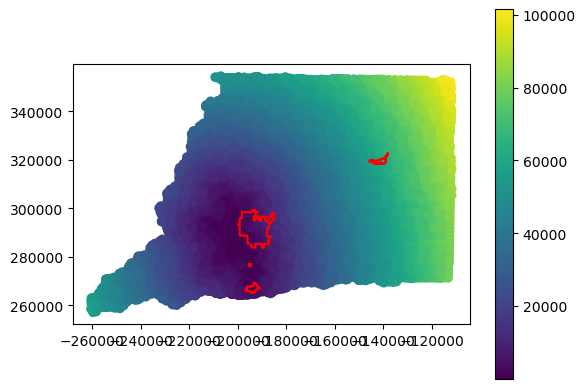

In [457]:
#sanity check on the distance calculated by plotting it
ax=parcel_pnts_2010.plot(column='dist2waterpipe',  legend=True)

#Overlay it with the County Water District Polygon
water_district=gpd.read_file(r".\county\Water_Districts.shp").to_crs(mycrs)
water_district.boundary.plot(color="red", ax=ax)

In [458]:
#create indicator column to indicate whether a parcel is inside the county water district boundary
parcel_pnts_2010.loc[:,'inWaterDistrictP']=0
parcel_pnts_2010.loc[parcel_pnts_2010.geometry.within(water_district.geometry.unary_union),'inWaterDistrictP']=1

In [459]:
#To be consistent with year 2012 parcel landuse layer, create a vancancy column to indicate whether the parcel has been developed or not
parcel_pnts_2010.loc[:,'Vacancy']=0
parcel_pnts_2010.loc[(parcel_pnts_2010.TOT_DU==0) & (parcel_pnts_2010.emptot_p==0),'Vacancy']=1

In [460]:
#sewer pipe feature
sewer_pipe_files=[r".\shasta\wwPipe.shp",
                  r".\redding\wwpipe.shp",
                   r".\anderson\wastewater.shp"]
sewer_lines=[]
for f in sewer_pipe_files:
    sewer_line = gpd.read_file(f).to_crs(mycrs)
    sewer_lines.append(sewer_line.geometry)

sewer_lines_gdf=gpd.GeoDataFrame(pd.concat(sewer_lines))
#calculate distance of parcel to water pipe
parcel_pnts_2010['dist2sewerpipe'] = parcel_pnts_2010.geometry.distance(sewer_lines_gdf.unary_union)
del sewer_lines_gdf

<Axes: >

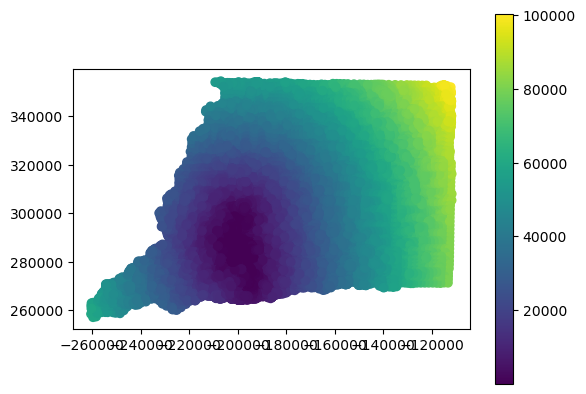

In [461]:
#Sanity check on parcel distance to sewer pipe
parcel_pnts_2010.plot(column='dist2sewerpipe', legend=True)  #the dist2sewerpipe and dist2waterpipe might be heavily correlated based on plot

In [462]:
parcel_pnts_2010[['dist2sewerpipe','inWaterDistrictP','dist2waterpipe']].corr()['dist2waterpipe']   #based on the plot the distance to water pipe seems to be heavily correlated to distanc to sewer, check corr to confirm

dist2sewerpipe      0.998958
inWaterDistrictP   -0.011010
dist2waterpipe      1.000000
Name: dist2waterpipe, dtype: float64

<Axes: >

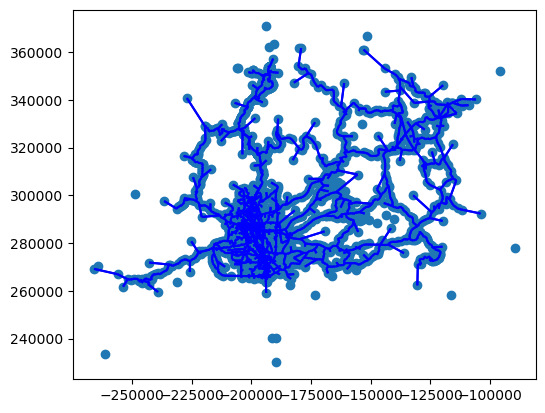

In [463]:
#read in modeling netwwork links and nodes
nodesfile=r".\modeling\FC_Master_nodes_110614_Proje.shp"
network_nodes=gpd.read_file(nodesfile).to_crs(mycrs)
edgesfile=r".\modeling\FC_Master_110614.shp"
network_edges=gpd.read_file(edgesfile).to_crs(mycrs)
ax=network_edges.plot(color='blue')
network_nodes.plot(ax=ax)

<Axes: >

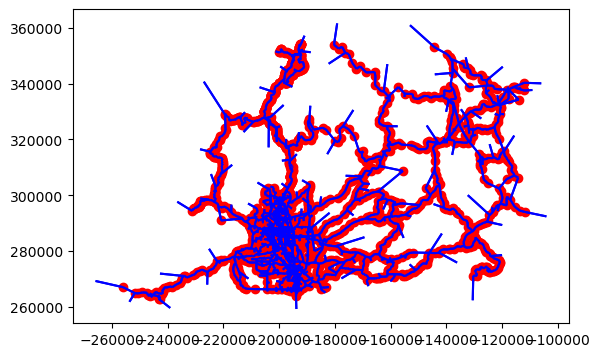

In [464]:
#count network nodes degrees
nodes_degrees=pd.concat([network_edges[['A','B']], network_edges[['B','A']].rename(columns={'B':'A','A':'B'})]).groupby('A')['B'].nunique()
ax=network_edges.plot(color='blue')

#remove dangling nodes from the network nodes layer
network_nodes=network_nodes.loc[network_nodes.N.isin(nodes_degrees.loc[nodes_degrees>1].index)]
network_nodes.plot(ax=ax, color='red')


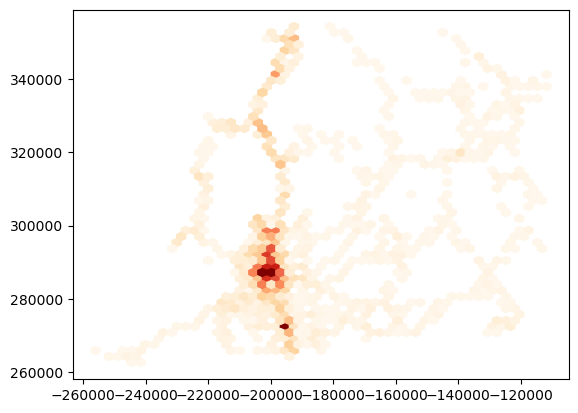

In [465]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
def polygons_from_hexbins(collection):
    hex_polys=collection.get_paths()[0].vertices
    hex_array=[]
    for xs, ys in collection.get_offsets():
        hex_x=np.add(hex_polys[:,0], xs)
        hex_y=np.add(hex_polys[:,1], ys)
        hex_array.append(Polygon(np.vstack([hex_x, hex_y]).T))
        
    counts=collection.get_array()
    return gpd.GeoDataFrame({'count': counts, 'geometry':hex_array})
        
cmap='OrRd'
#save matplot hexagon bin into a collection
collection=plt.hexbin(x=network_nodes.geometry.x, y=network_nodes.geometry.y, gridsize=50, cmap=cmap, mincnt=1,  vmax=100)

#convert the hexagon collection into geopandas dataframe        
hex_gdf=polygons_from_hexbins(collection).set_crs(mycrs)
hex_gdf.to_file('./hex_gdf_cntintersections.geojson', driver='GeoJSON')

In [466]:
#Join hexagon dataframe with parcel pnts data and apply the counts in the hexagon to every parcel inside the hexagon
parcel_pnts_2010=parcel_pnts_2010.sjoin(hex_gdf, how='left', predicate='within')
parcel_pnts_2010.drop(columns=['index_right'], inplace=True)
parcel_pnts_2010.rename(columns={'index_left':'index', 'count':'cnt_intersections'}, inplace=True)
parcel_pnts_2010['cnt_intersections']=parcel_pnts_2010['cnt_intersections'].fillna(0)

<Axes: >

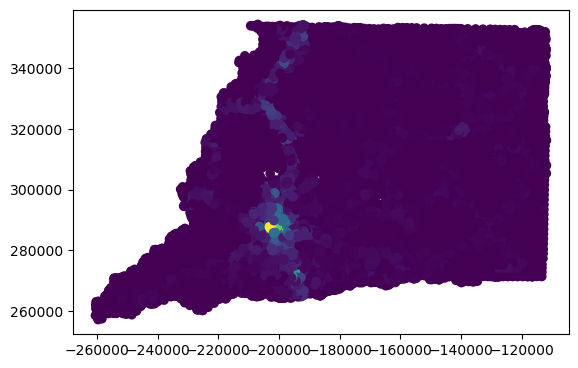

In [467]:
#Plot it for sanity check
parcel_pnts_2010.plot(column='cnt_intersections')

In [468]:
#check whether inside primary growth area or not
sga_f=r".\county\SGA.shp"
sga=gpd.read_file(sga_f).to_crs(mycrs)
parcel_pnts_2010.loc[:,'inSGA']=0
parcel_pnts_2010.loc[parcel_pnts_2010.geometry.within(sga.geometry.unary_union),'inSGA']=1
parcel_pnts_2010insga= parcel_pnts_2010.sjoin(sga, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010insga.index,'SGA']=parcel_pnts_2010insga['NAME']

In [469]:
del sga, parcel_pnts_2010insga

In [470]:
sga_f=r".\redding\growtharea.shp"
sga=gpd.read_file(sga_f).to_crs(mycrs)
sga

,OBJECTI,DESCRIP,GIS_ID,Shp__Ar,Shp__Ln,geometry
0,1.0,PRIMARY,3.0,8.779003e+05,5645.494152,"POLYGON ((-204909.458 291288.083, -204952.212 ..."
1,2.0,PRIMARY,4.0,3.303030e+06,13317.940507,"POLYGON ((-202084.367 295352.381, -202084.292 ..."
2,3.0,PRIMARY,5.0,1.069022e+06,5269.973927,"POLYGON ((-200320.948 285433.819, -200321.788 ..."
3,5.0,SECONDARY,18.0,9.582991e+06,19960.664815,"POLYGON ((-206952.810 291782.835, -206968.566 ..."
4,6.0,PRIMARY,6.0,4.972551e+05,4598.104652,"POLYGON ((-205428.156 284072.188, -205632.877 ..."
5,7.0,SECONDARY,19.0,3.850247e+06,13399.512846,"POLYGON ((-206178.920 285255.346, -206181.312 ..."
6,8.0,PRIMARY,7.0,5.615898e+06,10865.377977,"POLYGON ((-205712.786 280131.638, -205679.570 ..."
7,9.0,SECONDARY,20.0,3.482850e+06,8216.806646,"POLYGON ((-207322.245 280637.374, -206910.724 ..."
8,11.0,PRIMARY,8.0,3.271537e+06,12660.690816,"POLYGON ((-199141.032 278013.872, -198923.530 ..."
9,13.0,PRIMARY,9.0,4.741103e+05,4411.261785,"POLYGON ((-198422.561 282296.799, -198537.971 ..."


In [471]:
#redding has its own primary and secondary growth area
sga_f=r".\redding\growtharea.shp"
sga=gpd.read_file(sga_f).to_crs(mycrs)
parcel_pnts_2010.loc[parcel_pnts_2010.geometry.within(sga.geometry.unary_union),'inSGA']=1
parcel_pnts_2010.loc[:,'inPSGA']=0
parcel_pnts_2010.loc[parcel_pnts_2010.geometry.within(sga.loc[sga.DESCRIP=='PRIMARY'].geometry.unary_union),'inPSGA']=1
parcel_pnts_2010insga= parcel_pnts_2010.sjoin(sga, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010insga.index,'SGA']=parcel_pnts_2010insga['DESCRIP']
del sga, parcel_pnts_2010insga

<Axes: >

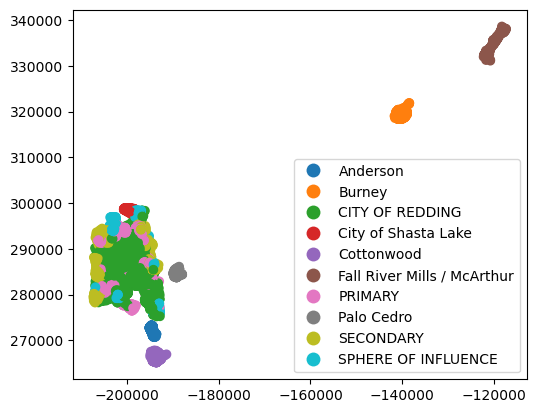

In [472]:
parcel_pnts_2010.plot(column='SGA',legend=True)

In [473]:
#read zoning of whole county
zoning_file=r".\county\Zoning.shp"
zoning=gpd.read_file(zoning_file).to_crs(mycrs)
parcel_pnts_2010inzoning= parcel_pnts_2010.sjoin(zoning, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning']=parcel_pnts_2010inzoning['ZONING']
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning_source']='County'
del zoning


In [474]:
#read zoning of redding
zoning_file=r".\redding\Zoning.shp"
zoning=gpd.read_file(zoning_file).to_crs(mycrs)
parcel_pnts_2010inzoning= parcel_pnts_2010.sjoin(zoning, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning']=parcel_pnts_2010inzoning['ZONING']
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning_source']='Redding'
del zoning
parcel_pnts_2010

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,dist2waterpipe,inWaterDistrictP,Vacancy,dist2sewerpipe,cnt_intersections,inSGA,SGA,inPSGA,zoning,zoning_source
0,49436,23899.0,1477,1011,1.0,0.0,0.0,0.0,1.0,1,...,4326.333461,0,0,4325.556800,13.0,0,NaN,0,R-R-T,County
1,49435,26843.0,1477,1011,0.0,0.0,0.0,1.0,1.0,0,...,4447.929688,0,0,4446.677129,13.0,0,NaN,0,R-R-T,County
2,49471,3107.0,1477,1010,0.0,0.0,0.0,0.0,0.0,0,...,4363.047640,0,1,4361.855967,13.0,0,NaN,0,R-R-T,County
3,49437,41596.0,1477,1011,2.0,0.0,0.0,0.0,2.0,1,...,4431.455036,0,0,4430.242178,13.0,0,NaN,0,R-R-T,County
4,49295,19490.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4106.337552,0,0,4108.994368,4.0,0,NaN,0,R-R-T,County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,49597,9736.0,1158,1010,0.0,0.0,0.0,0.0,0.0,0,...,4117.961796,0,1,4117.603860,13.0,0,NaN,0,A-1,County
93057,49577,9701.0,1158,1006,0.0,0.0,0.0,1.0,1.0,0,...,4351.013312,0,0,4350.673364,13.0,0,NaN,0,A-1-T,County
93058,49291,45094.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4220.078832,0,0,4222.827121,4.0,0,NaN,0,R-R-T,County
93059,49290,204074.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4304.850091,0,0,4307.582994,4.0,0,NaN,0,R-R-T,County


In [475]:
#read zoning of shasta lake
zoning_file=r".\shasta\Zone_Districts.shp"
zoning=gpd.read_file(zoning_file).to_crs(mycrs)
parcel_pnts_2010inzoning= parcel_pnts_2010.sjoin(zoning, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning']=parcel_pnts_2010inzoning['ZONE_ID']
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning_source']='Shasta Lake'
del zoning
parcel_pnts_2010

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,dist2waterpipe,inWaterDistrictP,Vacancy,dist2sewerpipe,cnt_intersections,inSGA,SGA,inPSGA,zoning,zoning_source
0,49436,23899.0,1477,1011,1.0,0.0,0.0,0.0,1.0,1,...,4326.333461,0,0,4325.556800,13.0,0,NaN,0,R-R-T,County
1,49435,26843.0,1477,1011,0.0,0.0,0.0,1.0,1.0,0,...,4447.929688,0,0,4446.677129,13.0,0,NaN,0,R-R-T,County
2,49471,3107.0,1477,1010,0.0,0.0,0.0,0.0,0.0,0,...,4363.047640,0,1,4361.855967,13.0,0,NaN,0,R-R-T,County
3,49437,41596.0,1477,1011,2.0,0.0,0.0,0.0,2.0,1,...,4431.455036,0,0,4430.242178,13.0,0,NaN,0,R-R-T,County
4,49295,19490.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4106.337552,0,0,4108.994368,4.0,0,NaN,0,R-R-T,County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,49597,9736.0,1158,1010,0.0,0.0,0.0,0.0,0.0,0,...,4117.961796,0,1,4117.603860,13.0,0,NaN,0,A-1,County
93057,49577,9701.0,1158,1006,0.0,0.0,0.0,1.0,1.0,0,...,4351.013312,0,0,4350.673364,13.0,0,NaN,0,A-1-T,County
93058,49291,45094.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4220.078832,0,0,4222.827121,4.0,0,NaN,0,R-R-T,County
93059,49290,204074.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4304.850091,0,0,4307.582994,4.0,0,NaN,0,R-R-T,County


In [476]:
#read zoning of Anderson City
zoning_file=r".\anderson\zoning.shp"
zoning=gpd.read_file(zoning_file).to_crs(mycrs)
parcel_pnts_2010inzoning= parcel_pnts_2010.sjoin(zoning, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning']=parcel_pnts_2010inzoning['zone_cd']
parcel_pnts_2010.loc[parcel_pnts_2010inzoning.index,'zoning_source']='Anderson'
del zoning
parcel_pnts_2010

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,dist2waterpipe,inWaterDistrictP,Vacancy,dist2sewerpipe,cnt_intersections,inSGA,SGA,inPSGA,zoning,zoning_source
0,49436,23899.0,1477,1011,1.0,0.0,0.0,0.0,1.0,1,...,4326.333461,0,0,4325.556800,13.0,0,NaN,0,R-R-T,County
1,49435,26843.0,1477,1011,0.0,0.0,0.0,1.0,1.0,0,...,4447.929688,0,0,4446.677129,13.0,0,NaN,0,R-R-T,County
2,49471,3107.0,1477,1010,0.0,0.0,0.0,0.0,0.0,0,...,4363.047640,0,1,4361.855967,13.0,0,NaN,0,R-R-T,County
3,49437,41596.0,1477,1011,2.0,0.0,0.0,0.0,2.0,1,...,4431.455036,0,0,4430.242178,13.0,0,NaN,0,R-R-T,County
4,49295,19490.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4106.337552,0,0,4108.994368,4.0,0,NaN,0,R-R-T,County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,49597,9736.0,1158,1010,0.0,0.0,0.0,0.0,0.0,0,...,4117.961796,0,1,4117.603860,13.0,0,NaN,0,A-1,County
93057,49577,9701.0,1158,1006,0.0,0.0,0.0,1.0,1.0,0,...,4351.013312,0,0,4350.673364,13.0,0,NaN,0,A-1-T,County
93058,49291,45094.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4220.078832,0,0,4222.827121,4.0,0,NaN,0,R-R-T,County
93059,49290,204074.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,4304.850091,0,0,4307.582994,4.0,0,NaN,0,R-R-T,County


In [477]:
#Set Undevelopable Parcel by Zoning
parcel_pnts_2010.loc[(parcel_pnts_2010.zoning.fillna('').str.startswith('A-1'))  |
               (parcel_pnts_2010.zoning.fillna('').str.startswith('F-1')) | 
               (parcel_pnts_2010.zoning.fillna('').str.startswith('EA')) |
               (parcel_pnts_2010.zoning.fillna('').str.startswith('TP')) |
               (parcel_pnts_2010.zoning.fillna('').str.startswith('MR')) |
               (parcel_pnts_2010.zoning.fillna('').str.startswith('HP')) |
               (parcel_pnts_2010.zoning.fillna('').str.startswith('OS')) |
               (parcel_pnts_2010.zoning.fillna('').str.startswith('NRA-S')) |
               (parcel_pnts_2010.zoning.fillna('').str.startswith('NRA-WI')),'devstatus']='Undevelopable'

In [478]:
#read generalplan of whole county
gp_file=r".\county\GeneralPlan.shp"
gp=gpd.read_file(gp_file).to_crs(mycrs)
gp

,OBJECTID,GP_Designa,GP_Descrip,GPArea_Nam,PA_Type,PA_Name,Resid_Dens,IntMinRes,MinResBuf,QA_Review,...,ShastaGeo_,Acres,Designatio,Source,SubType,FID_GP,ORIG_FID,Shape__Are,Shape__Len,geometry
0,27235,PUB,Public Land,WU,None,ShastaCoGP,NaN,No,No,No,...,None,None,None,County_GP_LandUse,1,1498.0,48456.0,1.237004e+08,139496.368977,"POLYGON ((-248752.684 270049.348, -248734.135 ..."
1,27236,PUB,Public Land,WU,None,ShastaCoGP,NaN,No,No,No,...,None,None,None,County_GP_LandUse,1,1503.0,48466.0,1.214274e+06,7333.263936,"POLYGON ((-243971.176 263894.888, -243847.327 ..."
2,27237,N-H-80,Habitat Resource 80 acre density,WU,None,ShastaCoGP,NaN,No,No,No,...,None,None,None,County_GP_LandUse,1,1501.0,48459.0,1.277748e+08,115333.359264,"POLYGON ((-244302.258 267108.388, -244241.281 ..."
3,27238,RB,Rural Residential B,WU,None,Platina,0.33,No,No,No,...,None,None,None,Platina_RCC_LandUse,2,1765.0,49164.0,2.164814e+06,8660.875881,"POLYGON ((-247280.130 263700.198, -247202.034 ..."
4,27239,RA,Rural Residential A,WU,None,Platina,1.00,No,No,No,...,None,None,None,Platina_RCC_LandUse,2,1763.0,49162.0,1.234686e+06,6079.686426,"POLYGON ((-246665.517 264431.209, -246614.783 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,28832,C,Commercial,SCR,GP,ShastaCoGP,NaN,No,No,No,...,None,None,None,County_GP_LandUse,1,276.0,46887.0,1.375849e+04,509.565423,"POLYGON ((-206178.919 285255.346, -206148.857 ..."
1598,28833,N-H-RB-C,Habitat Resource-Rural Residential B-Day Bench...,NE,GP,ShastaCoGP,NaN,No,No,No,...,None,None,None,County_GP_LandUse,1,1099.0,47810.0,3.062149e+06,10070.601740,"POLYGON ((-112667.593 348070.379, -112668.659 ..."
1599,28834,N-H-RB-C,Habitat Resource-Rural Residential B-Day Bench...,NE,GP,ShastaCoGP,NaN,No,No,No,...,None,None,None,County_GP_LandUse,1,1132.0,47844.0,1.400328e+06,6371.932058,"POLYGON ((-113412.627 349344.663, -113411.978 ..."
1600,28835,RA,Rural Residential A,SCR,None,ShastaCoGP,1.00,No,No,No,...,None,None,None,County_GP_LandUse,1,1568.0,48722.0,5.400509e+07,139682.447191,"POLYGON ((-211943.196 292247.665, -211943.192 ..."


In [479]:
#create summary file to check
gp.loc[:,'Acres']=gp.geometry.area/4046.86
gp.groupby(['GP_Descrip','Resid_Dens'])['Acres'].sum().to_csv(r'.\gp_resid_dens.csv')
gp.groupby(['GP_Descrip','Resid_Dens'])['Acres'].sum()

GP_Descrip                        Resid_Dens
Open Space                        1.00              637.55731
Rural Residential A               1.00           94666.430429
Rural Residential B               0.33          169058.058726
Suburban Residential              3.00            8588.633681
                                  25.00             44.808565
Suburban Residential-1units/acre  1.00             604.324214
Suburban Residential-2units/acre  2.00             205.327429
Suburban Residential-3units/acre  3.00             508.312559
Urban Residential                 16.00            930.304181
Urban Residential-12units/acre    12.00             22.613045
Urban Residential-16units/acre    16.00              2.843724
Urban Residential-4units/acre     4.00              11.388814
Urban Residential-5units/acre     5.00             211.320189
Urban Residential-6units/acre     6.00             167.644872
Urban Residential-8units/acre     8.00              56.293933
Urban Residential-9units/

In [480]:
parcel_pnts_2010ingp= parcel_pnts_2010.sjoin(gp, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'GP_Designa']=parcel_pnts_2010ingp['GP_Designa']
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'GP_Descrip']=parcel_pnts_2010ingp['GP_Descrip']
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'gp_source']=parcel_pnts_2010ingp['Source']
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'Resid_Dens']=parcel_pnts_2010ingp['Resid_Dens']
del gp,parcel_pnts_2010ingp
parcel_pnts_2010

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,inSGA,SGA,inPSGA,zoning,zoning_source,devstatus,GP_Designa,GP_Descrip,gp_source,Resid_Dens
0,49436,23899.0,1477,1011,1.0,0.0,0.0,0.0,1.0,1,...,0,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0
1,49435,26843.0,1477,1011,0.0,0.0,0.0,1.0,1.0,0,...,0,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0
2,49471,3107.0,1477,1010,0.0,0.0,0.0,0.0,0.0,0,...,0,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0
3,49437,41596.0,1477,1011,2.0,0.0,0.0,0.0,2.0,1,...,0,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0
4,49295,19490.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,49597,9736.0,1158,1010,0.0,0.0,0.0,0.0,0.0,0,...,0,NaN,0,A-1,County,Undevelopable,A-cg,Agricultural Small Scale Cropland / Grazing,County_GP_LandUse,NaN
93057,49577,9701.0,1158,1006,0.0,0.0,0.0,1.0,1.0,0,...,0,NaN,0,A-1-T,County,Undevelopable,A-cg,Agricultural Small Scale Cropland / Grazing,County_GP_LandUse,NaN
93058,49291,45094.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0
93059,49290,204074.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0


In [481]:
#read generalplan of Redding
gp_file=r".\redding\General_Plan.shp"
gp=gpd.read_file(gp_file).to_crs(mycrs)
gp

,GPCLASS,geometry
0,1 to 5,"POLYGON ((-194545.550 298414.751, -194529.283 ..."
1,GWY,"POLYGON ((-195884.732 298444.652, -195267.748 ..."
2,GWY,"POLYGON ((-196583.456 298170.846, -196578.756 ..."
3,1 to 5,"POLYGON ((-196686.756 297398.699, -196684.906 ..."
4,GWY,"POLYGON ((-194436.391 298410.265, -194476.549 ..."
...,...,...
900,2 to 3.5,"POLYGON ((-198149.511 285919.751, -198149.585 ..."
901,GO,"POLYGON ((-198140.374 285570.239, -198140.247 ..."
902,10 to 20,"POLYGON ((-200349.631 286234.140, -200348.120 ..."
903,NC,"POLYGON ((-196820.363 286295.766, -196820.501 ..."


In [482]:
gp.GPCLASS.unique()

array(['1 to 5', 'GWY', '1 to 2', 'PK', 'PF-I', 'NC', '10 to 20', 'GC',
       'RC', '2 to 3.5', 'SC', '5 a/u', '3.5 to 6', 'LO', 'GO', '6 to 10',
       'HC', 'PF-I-S', 'PK-G', '20 to 30', 'REC', 'AS', 'GI', 'AO', 'HI',
       'MUC'], dtype=object)

In [483]:
#Extract the maximum capacity possible from GPCLASS
gp.GPCLASS.str.extract(r'(\d+(?:\.\d+)?) to (\d+(?:\.\d+)?)')[1]

0        5
1      NaN
2      NaN
3        5
4      NaN
      ... 
900    3.5
901    NaN
902     20
903    NaN
904    NaN
Name: 1, Length: 905, dtype: object

In [484]:
#Join genearl plan GPCLASS infor to parcel
parcel_pnts_2010ingp= parcel_pnts_2010.sjoin(gp, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'GPCLASS']=parcel_pnts_2010ingp['GPCLASS']
del gp,parcel_pnts_2010ingp
parcel_pnts_2010

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,SGA,inPSGA,zoning,zoning_source,devstatus,GP_Designa,GP_Descrip,gp_source,Resid_Dens,GPCLASS
0,49436,23899.0,1477,1011,1.0,0.0,0.0,0.0,1.0,1,...,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN
1,49435,26843.0,1477,1011,0.0,0.0,0.0,1.0,1.0,0,...,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN
2,49471,3107.0,1477,1010,0.0,0.0,0.0,0.0,0.0,0,...,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN
3,49437,41596.0,1477,1011,2.0,0.0,0.0,0.0,2.0,1,...,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN
4,49295,19490.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,49597,9736.0,1158,1010,0.0,0.0,0.0,0.0,0.0,0,...,NaN,0,A-1,County,Undevelopable,A-cg,Agricultural Small Scale Cropland / Grazing,County_GP_LandUse,NaN,NaN
93057,49577,9701.0,1158,1006,0.0,0.0,0.0,1.0,1.0,0,...,NaN,0,A-1-T,County,Undevelopable,A-cg,Agricultural Small Scale Cropland / Grazing,County_GP_LandUse,NaN,NaN
93058,49291,45094.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN
93059,49290,204074.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,NaN,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN


In [485]:
#Update Res density based on GPCLASS 
selclasses=['1 to 5',  '1 to 2',  '10 to 20', '2 to 3.5', '3.5 to 6', '6 to 10', '20 to 30']

parcel_pnts_2010.loc[parcel_pnts_2010.GPCLASS.isin(selclasses), 'Resid_Dens']=parcel_pnts_2010.loc[parcel_pnts_2010.GPCLASS.isin(selclasses),'GPCLASS'].str.extract(r'(\d+(?:\.\d+)?) to (\d+(?:\.\d+)?)')[1].astype('f')
parcel_pnts_2010.loc[parcel_pnts_2010.GPCLASS=='5 a/u', 'Resid_Dens']=0.2

In [486]:
#read generalplan of Shasta
gp_file=r".\shasta\General_Plan_2040_(GeneralPlan_LandUse).shp"
gp=gpd.read_file(gp_file).to_crs(mycrs)
gp

,PrefLUGP20,PrefLUGP_C,LU_Desc,DocumentLi,IZO_Docume,geometry
0,Industrial,I,Provides for industrial uses. Specific catego...,https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-201359.546 297595.190, -201366.380 ..."
1,Industrial,I,Provides for industrial uses. Specific catego...,https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-201535.707 296971.966, -201550.153 ..."
2,Industrial,I,Provides for industrial uses. Specific catego...,https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-202325.918 297391.965, -202333.402 ..."
3,Mixed Use,MU,"Mixed-Use provides for residential, commercial...",https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-198867.119 297234.824, -198869.016 ..."
4,Mixed Use,MU,"Mixed-Use provides for residential, commercial...",https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-198237.595 299878.321, -198244.647 ..."
...,...,...,...,...,...,...
602,Village Mixed Use,VMU,Village Mixed-Use serves as primary nodes of b...,https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-199286.908 298456.647, -199329.516 ..."
603,Village Mixed Use,VMU,Village Mixed-Use serves as primary nodes of b...,https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-199501.874 298440.420, -199502.697 ..."
604,Village Mixed Use,VMU,Village Mixed-Use serves as primary nodes of b...,https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-200299.164 298539.212, -200300.490 ..."
605,Village Mixed Use,VMU,Village Mixed-Use serves as primary nodes of b...,https://www.cityofshastalake.org/DocumentCente...,https://www.cityofshastalake.org/DocumentCente...,"POLYGON ((-200576.006 298595.690, -200581.385 ..."


In [487]:
gp['IZO_Docume'][0]

'https://www.cityofshastalake.org/DocumentCenter/View/3768/Codified-Interim-Zoning-Ordinance-IZO'

In [488]:
parcel_pnts_2010ingp= parcel_pnts_2010.sjoin(gp, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'GP_Designa']=parcel_pnts_2010ingp['PrefLUGP_C']
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'GP_Descrip']=parcel_pnts_2010ingp['LU_Desc']
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'PrefLUGP20']=parcel_pnts_2010ingp['PrefLUGP20']
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'gp_source']='Shasta Lake'
del gp,parcel_pnts_2010ingp
parcel_pnts_2010.columns

Index(['parcelid', 'sqft_p', 'taz_p', 'block_p', 'SFDU', 'MF2_4DU', 'MF5+DU',
       'MHDU', 'TOT_DU', 'SFHH', 'MF2_4HH', 'MF5+HH', 'MHHH', 'TOT_HH',
       'stugrd_p', 'stuhgh_p', 'stuuni_p', 'empedu_p', 'empfoo_p', 'empgov_p',
       'empind_p', 'empmed_p', 'empofc_p', 'empret_p', 'empsvc_p', 'empoth_p',
       'emptot_p', 'parkdy_p', 'parkhr_p', 'ppricdyp', 'pprichrp', 'track',
       'group', 'APN_2010', 'APN_2012', 'APN_2023', 'revert', 'geometry',
       'dist2waterpipe', 'inWaterDistrictP', 'Vacancy', 'dist2sewerpipe',
       'cnt_intersections', 'inSGA', 'SGA', 'inPSGA', 'zoning',
       'zoning_source', 'devstatus', 'GP_Designa', 'GP_Descrip', 'gp_source',
       'Resid_Dens', 'GPCLASS', 'PrefLUGP20'],
      dtype='object')

In [489]:
#read generalplan of Anderson
gp_file=r".\anderson\generalplan.shp"
gp=gpd.read_file(gp_file).to_crs(mycrs)
gp

,fid,desgntn,geometry
0,1.0,MIXED USE,"POLYGON ((-194466.322 272880.056, -194472.267 ..."
1,2.0,MIXED USE,"POLYGON ((-194680.751 272691.812, -194674.216 ..."
2,3.0,MIXED USE,"POLYGON ((-194872.753 272718.599, -194850.669 ..."
3,4.0,MIXED USE,"POLYGON ((-194980.372 272604.645, -194957.764 ..."
4,5.0,MIXED USE,"POLYGON ((-195086.298 272704.990, -195051.677 ..."
...,...,...,...
353,354.0,MEDIUM DENSITY RESIDENTIAL,"POLYGON ((-194767.341 274545.594, -194767.322 ..."
354,355.0,MEDIUM DENSITY RESIDENTIAL,"POLYGON ((-194498.030 274637.523, -194499.925 ..."
355,356.0,MEDIUM DENSITY RESIDENTIAL,"POLYGON ((-194847.861 274698.345, -194836.018 ..."
356,357.0,MEDIUM DENSITY RESIDENTIAL,"POLYGON ((-193344.185 274640.906, -193351.092 ..."


In [490]:
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Anderson']

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,inPSGA,zoning,zoning_source,devstatus,GP_Designa,GP_Descrip,gp_source,Resid_Dens,GPCLASS,PrefLUGP20
36,79671,44849.0,116,1072,0.0,0.0,0.0,0.0,0.0,0,...,0,AG/HS,Anderson,NaN,RB,Rural Residential B,County_GP_LandUse,0.33,NaN,NaN
221,78953,9590.0,102,2014,1.0,0.0,0.0,0.0,1.0,1,...,0,R1,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,80160,8990.0,118,2028,0.0,3.0,0.0,0.0,3.0,0,...,0,R1,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,80150,8491.0,118,2027,1.0,0.0,0.0,0.0,1.0,1,...,0,R1,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,77918,7860.0,158,2038,1.0,0.0,0.0,0.0,1.0,1,...,0,MU-C,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79021,77678,26057.0,172,3002,1.0,0.0,0.0,0.0,1.0,1,...,0,RE,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79023,77675,22103.0,172,3002,1.0,0.0,0.0,0.0,1.0,1,...,0,RE,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79053,78980,190.0,103,2000,0.0,0.0,0.0,0.0,0.0,0,...,0,PSP,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79328,79619,13120.0,129,4020,0.0,0.0,0.0,0.0,0.0,0,...,0,C1,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [491]:
parcel_pnts_2010ingp= parcel_pnts_2010.sjoin(gp, predicate='within', how='inner')
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'GP_Descrip']=parcel_pnts_2010ingp['desgntn']
parcel_pnts_2010.loc[parcel_pnts_2010ingp.index,'gp_source']='Anderson'
del gp,parcel_pnts_2010ingp
parcel_pnts_2010

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,inPSGA,zoning,zoning_source,devstatus,GP_Designa,GP_Descrip,gp_source,Resid_Dens,GPCLASS,PrefLUGP20
0,49436,23899.0,1477,1011,1.0,0.0,0.0,0.0,1.0,1,...,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN,NaN
1,49435,26843.0,1477,1011,0.0,0.0,0.0,1.0,1.0,0,...,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN,NaN
2,49471,3107.0,1477,1010,0.0,0.0,0.0,0.0,0.0,0,...,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN,NaN
3,49437,41596.0,1477,1011,2.0,0.0,0.0,0.0,2.0,1,...,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN,NaN
4,49295,19490.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,49597,9736.0,1158,1010,0.0,0.0,0.0,0.0,0.0,0,...,0,A-1,County,Undevelopable,A-cg,Agricultural Small Scale Cropland / Grazing,County_GP_LandUse,NaN,NaN,NaN
93057,49577,9701.0,1158,1006,0.0,0.0,0.0,1.0,1.0,0,...,0,A-1-T,County,Undevelopable,A-cg,Agricultural Small Scale Cropland / Grazing,County_GP_LandUse,NaN,NaN,NaN
93058,49291,45094.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN,NaN
93059,49290,204074.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0,R-R-T,County,NaN,RA,Rural Residential A,County_GP_LandUse,1.0,NaN,NaN


In [492]:
#update data types
selcols=['sqft_p', 'SFDU','MF2_4DU','MF5+DU','MHDU','TOT_DU','stugrd_p', 'stuhgh_p', 'stuuni_p', 'empedu_p', 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p','empofc_p', 'empret_p', 'empsvc_p', 'empoth_p', 'emptot_p']
parcel_pnts_2010[selcols] = parcel_pnts_2010[selcols].apply(pd.to_numeric, errors='coerce')
parcel_pnts_2010['GPCLASS']=parcel_pnts_2010['GPCLASS'].astype(str)

In [493]:
#output zoning and gp information for checking
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Shasta Lake'].groupby(['zoning','zoning_source', 'GP_Designa','GP_Descrip'])[selcols].sum().reset_index().to_csv(r'.\summaryby_zoningandgp_shastalake.csv')
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Anderson'].groupby(['zoning','zoning_source', 'GP_Descrip'])[selcols].sum().reset_index().to_csv(r'.\summaryby_zoningandgp_anderson.csv')
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Redding'].groupby(['zoning','zoning_source','GPCLASS'])[selcols].sum().reset_index().to_csv(r'.\summaryby_zoningandgp_redding.csv')

In [494]:
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Shasta Lake',['zoning','zoning_source', 'GP_Designa','GP_Descrip','Resid_Dens']]

,zoning,zoning_source,GP_Designa,GP_Descrip,Resid_Dens
2567,C-2-DR,Shasta Lake,Unknown,None,NaN
2570,C-2-DR,Shasta Lake,Unknown,None,NaN
5965,R-1-B-20,Shasta Lake,SR,Suburban Residential provides City services an...,NaN
7058,VC,Shasta Lake,VMU,Village Mixed-Use serves as primary nodes of b...,NaN
7325,VC,Shasta Lake,VMU,Village Mixed-Use serves as primary nodes of b...,NaN
...,...,...,...,...,...
82315,R-1-BSM,Shasta Lake,UR,Urban Residential provides living environments...,NaN
82316,R-1-BSM,Shasta Lake,UR,Urban Residential provides living environments...,NaN
82318,R-1-BSM,Shasta Lake,UR,Urban Residential provides living environments...,NaN
82458,R-1-B-12,Shasta Lake,SR,Suburban Residential provides City services an...,NaN


In [495]:
#Update Res Density for Shasta Lake Area based on the following dictionary
#if there is DU in the parcel with general plan designation other than those in the dict, use the current density
den_dict={'SR': 1, 'URH-B': 20, 'UR': 4, 'VMU': 8, 'RA': 0.2, 'RB': 1 , 'URH-A': 20}
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Shasta Lake','Resid_Dens']=parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Shasta Lake'].apply(lambda row: den_dict[row['GP_Designa']] if row['GP_Designa'] in den_dict else row['TOT_DU']*43560/row['sqft_p'], axis=1)

In [496]:
#Update Res Density for Anderson Area based on the following dictionary
#if there is DU in the parcel with general plan designation other than those in the dict, use the current density
den_dict={'HIGH DENSITY RESIDENTIAL': 20, 'MEDIUM DENSITY RESIDENTIAL': 8, 'LOW DENSITY RESIDENTIAL / HILLSIDE': 4, 'MIXED USE': 8, 'RURAL ESTATE': 0.2, 'RURAL HOLDING': 0.2 , 'Rural Residential B': 0.2}
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Anderson','Resid_Dens']=parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Anderson'].apply(lambda row: den_dict[row['GP_Descrip']] if row['GP_Descrip'] in den_dict else row['TOT_DU']*43560/row['sqft_p'], axis=1)

In [497]:
#Update residential density for Reddings based on both zoning and general plan information 
#if there is zoning information then use zoning rather than general plan information
import re
def extract_zoningresdens(x):
    matches = re.findall(r'.+-(\d+(?:\.\d+)?)$', x)
    return float(matches[0]) if matches else 0

parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Redding','Resid_Dens']=parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Redding'].apply(lambda row: row['Resid_Dens'] if extract_zoningresdens(row['zoning'])==0 else extract_zoningresdens(row['zoning']), axis=1 )

In [498]:
parcel_pnts_2010.loc[parcel_pnts_2010.zoning_source=='Redding',['zoning','GPCLASS','Resid_Dens']]

,zoning,GPCLASS,Resid_Dens
403,RS-2,GWY,2.0
404,RS-3,2 to 3.5,3.0
405,OS,GWY,NaN
406,GC,GC,NaN
407,RM-9,GC,9.0
...,...,...,...
92504,RS-3,2 to 3.5,3.0
92505,OS,GWY,NaN
92509,RS-3,2 to 3.5,3.0
92579,RS-2.5,2 to 3.5,2.5


In [499]:
#construct census geoid using tract and block field 
parcel_pnts_2010['GEOID']=parcel_pnts_2010.apply(lambda x: '06089'+x['track'].zfill(6)+x['block_p'], axis=1)

In [500]:
sld_fpath=r'.\SLD_06089.parquet'
if os.path.isfile(sld_fpath):
    SLD=pd.read_parquet(sld_fpath)
else:
    # Get state data from SLD file GDB
    fgdb = "../../input/smart-location-database-v3/SmartLocationDatabase.gdb"
    # Construct the query
    st_fc = "06"  # Replace with the actual state code
    cntyfips = "089"  # Replace with the actual county code
    #query = f"STATEFP == '{st_fc}' and COUNTYFP == '{cntyfips}'"

    # Read data based on the query
    #SLD = gpd.read_file(fgdb, layer="EPA_SLD_Database_V3", bbox=tuple(pnt2010jntbldsqft.total_bounds))
    SLD = gpd.read_file(fgdb, layer="EPA_SLD_Database_V3")
    
    #keep only shasta's data
    SLD=SLD.loc[(SLD.STATEFP=='06') & (SLD.COUNTYFP=='089')]
    
    # Deal with negative values in transit access
    SLD["D5AR"] = SLD["D5AR"].clip(lower=0)
    SLD["D5BR"] = SLD["D5BR"].clip(lower=0)

    # Normalize SLD variables
    hu_density_max = SLD["D1A"].max()
    pop_density_max = SLD["D1B"].max()
    job_density_max = SLD["D1C"].max()
    jph_balance_max = SLD["D2A_JPHH"].max()
    wrkperjob_max = SLD["D2A_WRKEMP"].max()
    design_max = SLD["D3B"].max()
    NatWalkInd_max = SLD["NatWalkInd"].max()
    job_auto45_max = SLD["D5AR"].max()
    wrk_auto45_max = SLD["D5AE"].max()
    job_tran45_max = SLD["D5BR"].max()
    wrk_tran45_max = SLD["D5BE"].max()
    network_density_max=SLD["D3B"].max()

    # Create new columns with normalized values
    SLD["is_MPO"] = SLD["CBSA_POP"].map(lambda x: 1 if x>=50000 else 0)
    SLD["is_TMA"] = SLD["CBSA_POP"].map(lambda x: 1 if x>=200000 else 0)
    SLD["hu_density_1"] = SLD["D1A"]/hu_density_max
    SLD["pop_density_1"] = SLD["D1B"]/pop_density_max
    SLD["job_density_1"] = SLD["D1C"]/job_density_max
    SLD["jph_balance_1"] = SLD["D2A_JPHH"]/jph_balance_max
    SLD["emp_entropy"] = SLD["D2B_E5MIX"]
    SLD["mix_entropy"] = SLD["D2A_EPHHM"]
    SLD["wrkperjob_1"] = SLD["D2A_WRKEMP"]/wrkperjob_max
    SLD["design_1"] = SLD["D3B"]/design_max
    SLD["stop_025mi"] = SLD["D4B025"]
    SLD["stop_050mi"] = SLD["D4B050"]
    SLD["NatWalkInd_1"] = SLD["NatWalkInd"]/NatWalkInd_max
    SLD["job_auto45_1"]= SLD["D5AR"]/job_auto45_max
    SLD["wrk_auto45_1"]= SLD["D5AE"]/wrk_auto45_max
    SLD["job_tran45_1"]= SLD["D5BR"]/job_tran45_max
    SLD["wrk_tran45_1"]= SLD["D5BE"]/wrk_tran45_max
    SLD["network_density_1"]= SLD["D3A"]/network_density_max


    selcols=['GEOID10','GEOID20','COUNTYFP','TRACTCE','BLKGRPCE',"is_MPO","is_TMA","hu_density_1","pop_density_1","job_density_1","jph_balance_1","emp_entropy","mix_entropy","wrkperjob_1","design_1","stop_025mi","stop_050mi","NatWalkInd_1","job_auto45_1","wrk_auto45_1","job_tran45_1","wrk_tran45_1","network_density_1"]
    SLD=pd.DataFrame(SLD[selcols])

    SLD.to_parquet(sld_fpath, index=False, compression='snappy')
    

In [501]:
#Apply block group SLD data to each block inside the block group
blk10_089_f=r".\tl_2010_06089_tabblock10.shp"
blk10_089=gpd.read_file(blk10_089_f)
blk10_089['BGID']=blk10_089['GEOID10'].map(lambda x: x[:12])
blk10_089['block_p']=blk10_089['GEOID10'].map(lambda x: x[-4:])
blk10_089=pd.DataFrame(blk10_089[['block_p','BGID']])
blk10_089.merge(SLD, left_on='BGID', right_on='GEOID10')[['block_p']+SLD.columns.to_list()]

,block_p,GEOID10,GEOID20,COUNTYFP,TRACTCE,BLKGRPCE,is_MPO,is_TMA,hu_density_1,pop_density_1,...,mix_entropy,wrkperjob_1,design_1,stop_025mi,stop_050mi,NatWalkInd_1,job_auto45_1,wrk_auto45_1,job_tran45_1,wrk_tran45_1
0,1141,060890125001,060890125001,089,012500,1,1,0,0.000823,0.000456,...,0.562164,0.032146,0.006928,0.0,0.0,0.284404,0.009291,0.013762,0.0,-6.474103
1,1080,060890125001,060890125001,089,012500,1,1,0,0.000823,0.000456,...,0.562164,0.032146,0.006928,0.0,0.0,0.284404,0.009291,0.013762,0.0,-6.474103
2,1173,060890126041,060890126041,089,012604,1,1,0,0.000964,0.000819,...,0.596497,0.036287,0.006086,0.0,0.0,0.247706,0.011824,0.022019,0.0,-6.474103
3,2128,060890126042,060890126042,089,012604,2,1,0,0.002051,0.001981,...,0.302447,0.146484,0.004666,0.0,0.0,0.229358,0.308036,0.352451,0.0,-6.474103
4,1281,060890126031,060890126031,089,012603,1,1,0,0.002673,0.001211,...,0.138229,0.398174,0.006631,0.0,0.0,0.183486,0.001026,0.016960,0.0,-6.474103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10559,2017,060890126032,060890126032,089,012603,2,1,0,0.013868,0.013286,...,0.266370,0.141267,0.021199,0.0,0.0,0.229358,0.041747,0.069181,0.0,-6.474103
10560,3097,060890126033,060890126033,089,012603,3,1,0,0.015240,0.012209,...,0.233531,0.206336,0.031550,0.0,0.0,0.192661,0.043919,0.067693,0.0,-6.474103
10561,1290,060890126011,060890126011,089,012601,1,1,0,0.001264,0.001298,...,0.273535,0.155488,0.005288,0.0,0.0,0.220183,0.011040,0.041211,0.0,-6.474103
10562,1343,060890126011,060890126011,089,012601,1,1,0,0.001264,0.001298,...,0.273535,0.155488,0.005288,0.0,0.0,0.220183,0.011040,0.041211,0.0,-6.474103


In [502]:
#add '0' to the left of track to turn it into proper tract format
parcel_pnts_2010['TRACTCE']=parcel_pnts_2010['track'].map(lambda x: x.zfill(6))

In [503]:
#Join Smart location data with parcel via block layer
parcel_pnts_2010=parcel_pnts_2010.merge(blk10_089.merge(SLD, left_on='BGID', right_on='GEOID10')[['block_p']+SLD.columns.to_list()],on=['block_p','TRACTCE'], how='left')
parcel_pnts_2010.rename(columns = {"hu_density_1":"hu_density", "pop_density_1":"pop_density", "job_density_1":"job_density", 
                     "jph_balance_1":"jph_balance", "wrkperjob_1":"wrkperjob", "design_1":"design",
                     "NatWalkInd_1":"NatWalkInd", "job_auto45_1":"job_auto45","wrk_auto45_1":"wrk_auto45",
                     "job_tran45_1":"job_tran45","wrk_tran45_1":"wrk_tran45",
                     "jwrk_tran45_1":"jwrk_tran45","network_density_1":"network_density"}, inplace=True)
parcel_pnts_2010

,parcelid,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,TOT_DU,SFHH,...,mix_entropy,wrkperjob,design,stop_025mi,stop_050mi,NatWalkInd,job_auto45,wrk_auto45,job_tran45,wrk_tran45
0,49436,23899.0,1477,1011,1.0,0.0,0.0,0.0,1.0,1,...,0.141302,0.542021,0.016672,0.0,0.0,0.229358,0.264599,0.378041,0.0,-6.474103
1,49435,26843.0,1477,1011,0.0,0.0,0.0,1.0,1.0,0,...,0.141302,0.542021,0.016672,0.0,0.0,0.229358,0.264599,0.378041,0.0,-6.474103
2,49471,3107.0,1477,1010,0.0,0.0,0.0,0.0,0.0,0,...,0.141302,0.542021,0.016672,0.0,0.0,0.229358,0.264599,0.378041,0.0,-6.474103
3,49437,41596.0,1477,1011,2.0,0.0,0.0,0.0,2.0,1,...,0.141302,0.542021,0.016672,0.0,0.0,0.229358,0.264599,0.378041,0.0,-6.474103
4,49295,19490.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0.648759,0.031165,0.029546,0.0,0.0,0.412844,0.265746,0.329986,0.0,-6.474103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,49597,9736.0,1158,1010,0.0,0.0,0.0,0.0,0.0,0,...,0.141302,0.542021,0.016672,0.0,0.0,0.229358,0.264599,0.378041,0.0,-6.474103
93057,49577,9701.0,1158,1006,0.0,0.0,0.0,1.0,1.0,0,...,0.141302,0.542021,0.016672,0.0,0.0,0.229358,0.264599,0.378041,0.0,-6.474103
93058,49291,45094.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0.648759,0.031165,0.029546,0.0,0.0,0.412844,0.265746,0.329986,0.0,-6.474103
93059,49290,204074.0,1477,2076,1.0,0.0,0.0,0.0,1.0,1,...,0.648759,0.031165,0.029546,0.0,0.0,0.412844,0.265746,0.329986,0.0,-6.474103


In [504]:
#Get 9 neibors
import numpy as np
from sklearn.neighbors import BallTree
k=8
# the formula to calculate radiant required by haversine
parcel_pnts_2010['lat_rad'] = np.deg2rad(parcel_pnts_2010.geometry.to_crs(4326).y)
parcel_pnts_2010['lon_rad'] = np.deg2rad(parcel_pnts_2010.geometry.to_crs(4326).x)

ball_tree = BallTree(parcel_pnts_2010[["lat_rad", "lon_rad"]], metric="haversine")

neighbors = ball_tree.query(
    parcel_pnts_2010[["lat_rad", "lon_rad"]],
    k=(
        k + 1
    ),  # k + 1 because we remove the address itself later, hence we need k - 1 = k_desired
    return_distance=False,  
    sort_results=True,
)

neighbors


array([[    0, 90880, 90882, ..., 78642, 78643, 90884],
       [    1,     3, 90879, ..., 90869, 78644, 78424],
       [    2, 90884, 78643, ..., 90885, 90883, 90889],
       ...,
       [93058, 90815, 90814, ..., 90715, 90714, 90845],
       [93059, 93058, 90816, ..., 90814, 90845, 90818],
       [93060, 90816, 90823, ..., 90817, 90824, 78422]], dtype=int64)

In [505]:
# Save to an NPY file
np.save('../data/neighbors.npy', neighbors)
nei_parcel = pd.DataFrame(index=parcel_pnts_2010.index)
ncols=['neighbors_PARCEL_SQFT','neighbors_totalunits','neighbors_sfunits','neighbors_totaljobs','neighbors_retjobs', 'neighbors_totvancy']
for c in ncols:
   nei_parcel[c]=None
# remove the address/point itself from the array because it itself is its nearest neighbour
neighbors = neighbors[:, 1:]
#calculate neiboring parcels total land sqft
nei_parcel['neighbors_PARCEL_SQFT']= [
    parcel_pnts_2010['sqft_p'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring total housing units
nei_parcel['neighbors_totalunits']= [
    parcel_pnts_2010['TOT_DU'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring total households
nei_parcel['neighbors_totalhh']= [
    parcel_pnts_2010['TOT_HH'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring total sf units
nei_parcel['neighbors_sfunits']= [
    parcel_pnts_2010['SFDU'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring parcels total jobs
nei_parcel['neighbors_totaljobs']= [
    parcel_pnts_2010['emptot_p'].iloc[n].sum() for n in neighbors
    ]

jobcates=parcel_pnts_2010.columns[parcel_pnts_2010.columns.str.startswith('emp')] #list of job categories
for k in jobcates:
     #calculate neiboring parcels total ret jobs
        nei_parcel['neighbors_'+k]= [
        parcel_pnts_2010[k].iloc[n].sum() for n in neighbors
    ]               


#calculate neiboring parcels total vacant
nei_parcel['neighbors_totvacancy']= [
    parcel_pnts_2010['Vacancy'].iloc[n].sum() for n in neighbors
    ]

#calculate neighboring parcels average percentage of improved value and FAR ratio
parcel_pnts_2010.loc[:,'neighbors_hudensity']=nei_parcel['neighbors_totalunits']*43560.0/nei_parcel['neighbors_PARCEL_SQFT'].map(lambda x: x if x>0 else 1) 
parcel_pnts_2010.loc[:,'neighbors_jobdensity']=nei_parcel['neighbors_totaljobs']*43560.0/nei_parcel['neighbors_PARCEL_SQFT'].map(lambda x: x if x>0 else 1) 

for k in jobcates:
        #calculate neiboring parcels total ret jobs
        if(k!='emptot_p'):
              parcel_pnts_2010.loc[:,'neighbors_per_'+k]=nei_parcel['neighbors_'+k]/nei_parcel['neighbors_emptot_p'].map(lambda x: x if x>0 else 1)
parcel_pnts_2010.loc[:,'neighbors_hhvshu']=1-nei_parcel['neighbors_totalhh']/nei_parcel['neighbors_totalunits'].map(lambda x: x if x>0 else 1)
parcel_pnts_2010.loc[:,'neighbors_per_sf']=1-nei_parcel['neighbors_sfunits']/nei_parcel['neighbors_totalunits'].map(lambda x: x if x>0 else 1)
parcel_pnts_2010.loc[:,'neighbors_per_blt']=1-nei_parcel['neighbors_totvacancy']/8.0

selcols=['neighbors_per_'+k for k in jobcates if k!='emptot_p']
def calculate_entropy(row):
    return -sum((row[col] * np.log(row[col]) if row[col]>0 else 0) for col in selcols)

parcel_pnts_2010.loc[:,'neighbors_jobentropy'] = parcel_pnts_2010.apply(calculate_entropy, axis=1).fillna(0)



In [506]:
output_path = r'.\year2010_pnts_wattr.parquet'
parcel_pnts_2010.to_parquet(output_path, index=False, compression='snappy')

In [507]:
#read in Parcels 2012 landuse, value data (use 2012 rather than 2010 because 2010 Parcel data has no attributes)
shata_carto=r"C:\Users\adc\Documents\Manhan\CAMuLand\input\srta\ShastaSIM-2-0-Updated\ShastaSIM_2_0\GIS\SRTA_Cartography.gdb"
Parcels_2012 = gpd.read_file(shata_carto, layer='Parcels_New_20120104').to_crs(mycrs)
Parcels_2012['calarea']=Parcels_2012.geometry.area
areabyapn2012=Parcels_2012.groupby('APN')['calarea'].sum().reset_index()
selcols=['APN','Own_Class','Imprv_Valu','LandValue','TotalValue','ExUseCode','ExUseDesc','Vacancy','geometry']
Parcels_2012=Parcels_2012.loc[Parcels_2012.APN.str.strip()!='', selcols]
Parcels_2012=Parcels_2012.drop_duplicates(subset='APN')
Parcels_2012=Parcels_2012.merge(areabyapn2012, on='APN', how='inner')
Parcels_2012['APN']=Parcels_2012['APN'].map(lambda x: x.replace('-',''))
Parcels_2012.rename(columns={'APN':'APN_2012'}, inplace=True)
Parcels_2012=  Parcels_2012.loc[Parcels_2012['APN_2012'].str.len() == 12]
Parcels_2012

,APN_2012,Own_Class,Imprv_Valu,LandValue,TotalValue,ExUseCode,ExUseDesc,Vacancy,geometry,calarea
0,085240033000,Private,$0,"$11,995","$11,995",6002.0,VACANT,1,"MULTIPOLYGON (((-196190.706 312664.109, -19618...",31851.432328
1,084170013000,Private,"$913,503","$87,412","$1,000,915",7106.0,RECREATIONAL,0,"MULTIPOLYGON (((-196428.284 312737.331, -19641...",226735.143896
2,083270001000,Private,"$10,000","$25,000","$35,000",1003.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-201234.468 321394.158, -20124...",994.317952
3,083270002000,Private,"$65,723","$25,364","$91,087",1099.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-201245.309 321372.295, -20125...",937.966863
4,083270003000,Private,"$47,782","$16,168","$63,950",7101.0,RECREATIONAL,0,"MULTIPOLYGON (((-201255.601 321351.538, -20126...",923.665365
...,...,...,...,...,...,...,...,...,...,...
92136,116260063000,Unknown,$0,,,0.0,,0,"MULTIPOLYGON (((-199217.623 291230.336, -19921...",203.278583
92137,116260061000,Unknown,$0,,,0.0,,0,"MULTIPOLYGON (((-199231.651 291228.077, -19922...",1352.300708
92138,205190067000,Unknown,$0,,,0.0,,0,"MULTIPOLYGON (((-203557.293 274657.603, -20366...",15031.534906
92139,055250029000,Unknown,$0,,,0.0,,0,"MULTIPOLYGON (((-198506.778 278598.828, -19841...",2443.287529


<Axes: >

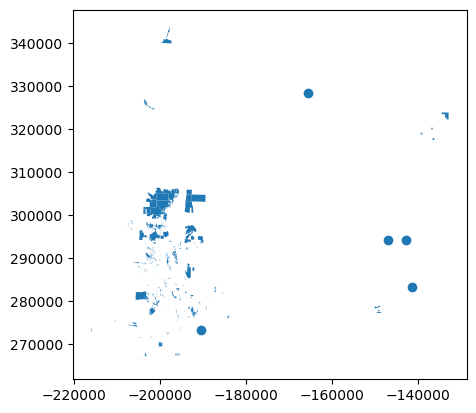

In [508]:
#read osm water, wetland, wood and park data which will be used to calculate usable land in each parcel
water_file=r".\county\water.geojson"
water=gpd.read_file(water_file).to_crs(mycrs)
wetland_file=r".\county\wetland.geojson"
wetland=gpd.read_file(wetland_file).to_crs(mycrs)
wood_file=r".\county\wood.geojson"
wood=gpd.read_file(wood_file).to_crs(mycrs)
park_file=r".\county\park.geojson"
park=gpd.read_file(park_file).to_crs(mycrs)
wood.plot()


In [509]:
#Calcualte Water Body Size in each Parcel
o_gdf=gpd.overlay(Parcels_2012, water.loc[water.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
waterinparcel=o_gdf.groupby('APN_2012')['o_area'].sum()
Parcels_2012=Parcels_2012.merge(waterinparcel, on='APN_2012', how='left')
Parcels_2012.rename(columns={'o_area':'water'}, inplace=True)

#Calcualte Wetland Body Size in each Parcel
o_gdf=gpd.overlay(Parcels_2012, wetland.loc[wetland.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
wetlandinparcel=o_gdf.groupby('APN_2012')['o_area'].sum()
Parcels_2012=Parcels_2012.merge(wetlandinparcel, on='APN_2012', how='left')
Parcels_2012.rename(columns={'o_area':'wetland'}, inplace=True)

#Calcualte Wood Size in each Parcel
o_gdf=gpd.overlay(Parcels_2012, wood.loc[wood.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
woodinparcel=o_gdf.groupby('APN_2012')['o_area'].sum()
Parcels_2012=Parcels_2012.merge(woodinparcel, on='APN_2012', how='left')
Parcels_2012.rename(columns={'o_area':'wood'}, inplace=True)

#Calcualte Park Size in each Parcel
o_gdf=gpd.overlay(Parcels_2012, park.loc[park.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
parkinparcel=o_gdf.groupby('APN_2012')['o_area'].sum()
Parcels_2012=Parcels_2012.merge(woodinparcel, on='APN_2012', how='left')
Parcels_2012.rename(columns={'o_area':'park'}, inplace=True)

Parcels_2012[['water','wood','wetland','park']]=Parcels_2012[['water','wood','wetland','park']].fillna(0)

In [510]:
#Merge parcel 2012 layer with modeling parcel pnts data
Parcels_2012=Parcels_2012.merge(pd.DataFrame(parcel_pnts_2010.loc[parcel_pnts_2010.APN_2012.str.len()==12].drop(columns='geometry')), on='APN_2012', how='inner').copy()

In [511]:
Parcels_2012.columns

Index(['APN_2012', 'Own_Class', 'Imprv_Valu', 'LandValue', 'TotalValue',
       'ExUseCode', 'ExUseDesc', 'Vacancy_x', 'geometry', 'calarea',
       ...
       'neighbors_per_empmed_p', 'neighbors_per_empofc_p',
       'neighbors_per_empret_p', 'neighbors_per_empsvc_p',
       'neighbors_per_empoth_p', 'neighbors_per_emp_entropy',
       'neighbors_hhvshu', 'neighbors_per_sf', 'neighbors_per_blt',
       'neighbors_jobentropy'],
      dtype='object', length=108)

In [512]:
#Normalize a couple fields
Parcels_2012.loc[:,'dist2waterpipe_n']=Parcels_2012.loc[:,'dist2waterpipe']/Parcels_2012.loc[:,'dist2waterpipe'].max()
Parcels_2012.loc[:,'cnt_intersections_n']=Parcels_2012.loc[:,'cnt_intersections']/Parcels_2012.loc[:,'cnt_intersections'].max()
Parcels_2012.loc[:,'neighbors_hudensity_n']=np.log(Parcels_2012.loc[:,'neighbors_hudensity'].map(lambda x: 1 if (x==0) | (x is None) else x))/np.log(Parcels_2012.loc[:,'neighbors_hudensity'].max())
Parcels_2012.loc[:,'neighbors_jobdensity_n']=np.log(Parcels_2012.loc[:,'neighbors_jobdensity'].map(lambda x: 1 if (x==0) | (x is None) else x))/np.log(Parcels_2012.loc[:,'neighbors_jobdensity'].max())



In [513]:
p2012vs2023=pd.read_csv(r'.\p2012vs2023.csv')
p2012vs2023['apn2012']=p2012vs2023['apn2012'].astype(str).str.zfill(12)
p2012vs2023['apn2023']=p2012vs2023['apn2023'].astype(str).str.zfill(12)
p2012vs2023

,apn2012,apn2023
0,202640027000,202640027000
1,115360004000,115360004000
2,202770042000,202770042000
3,104570015000,104570015000
4,201400043000,201400043000
...,...,...
54858,067310005000,067310005000
54859,104550037000,104550037000
54860,005260049000,005260049000
54861,306220026000,306220026000


In [514]:
#Query the year 2023 parcel char to get building informaiton
#get Parce 2023 landvalue and structure value data 
dataset_path = r"C:\Users\adc\Documents\Manhan\CAMuLand\input\srta\ParcelsGovAgencyExportExport.gdb" 

sha_new_pchars = gpd.read_file(dataset_path, driver='fileGDB', layer='sha_new_pchars', ignore_geometry=True)
sha_new_pccode = gpd.read_file(dataset_path, driver='fileGDB', layer='sha_new_pccode', ignore_geometry=True)

# Filter for BuildingType
sha_new_pchars['Value']=sha_new_pchars['Value'].str.strip()
sha_new_pccode['CodeValue']=sha_new_pccode['CodeValue'].str.strip()

# Filter for BuildingSize
a =sha_new_pchars.loc[sha_new_pchars['ResourceID'].str.strip() == 'BuildingSize', [
   'FeeParcel',
 'CatTypeA',
 'BldgSeqNum',
 'CatTypeB',
 'UnitSeqNum',
 'CatTypeC',
 'PoolSpa',
 'Value',
 'Bedrooms',
 'Baths',
 'HalfBaths'
]].rename(columns={'Value': 'BuildingSQFT'})


b=sha_new_pchars.loc[sha_new_pchars['ResourceID'].str.strip() == 'BuildingType'].merge(
    sha_new_pccode.loc[sha_new_pccode['ResourceID'].str.strip() == 'BuildingType'], left_on='Value', right_on='CodeValue', how='left')[
    ['FeeParcel', 'BldgSeqNum', 'UnitSeqNum', 'Descr']
].rename(columns={'Descr': 'BuildingType'})

# Filter for AttachGarageSF
c = sha_new_pchars.loc[sha_new_pchars['ResourceID'].str.strip() == 'AttachGarageSF', [
   'FeeParcel', 'BldgSeqNum', 'UnitSeqNum', 'Value'
]].rename(columns={'Value': 'AttachGarageSF'})

# Filter for DetachGarageSF
d = sha_new_pchars.loc[sha_new_pchars['ResourceID'].str.strip() == 'DetachGarageSF', [
    'FeeParcel', 'BldgSeqNum', 'UnitSeqNum', 'Value'
]].rename(columns={'Value': 'DetachGarageSF'})

# Filter for Year Built
e = sha_new_pchars.loc[sha_new_pchars['ResourceID'].str.strip() == 'YearBuilt', [
    'FeeParcel', 'BldgSeqNum', 'UnitSeqNum', 'Value'
]].rename(columns={'Value': 'YearBuilt'})

# Merge a, b,c,d
sha_new_pchars = pd.merge(a, b, on=['FeeParcel', 'BldgSeqNum', 'UnitSeqNum'], how='outer')
sha_new_pchars = pd.merge(sha_new_pchars, c, on=['FeeParcel', 'BldgSeqNum', 'UnitSeqNum'], how='outer')
sha_new_pchars = pd.merge(sha_new_pchars, d, on=['FeeParcel', 'BldgSeqNum', 'UnitSeqNum'], how='outer')
sha_new_pchars = pd.merge(sha_new_pchars, e, on=['FeeParcel', 'BldgSeqNum', 'UnitSeqNum'], how='outer')

sha_new_pchars['BuildingType']=sha_new_pchars['BuildingType'].str.strip()
# Combine for BuildingType
sha_new_pchars['agg_buildingtype'] = sha_new_pchars['BuildingType'].map({
    'Residence': 'SF',
    'Hobby Room/Office': 'ADU',
    'Duplex': 'MF2to4',
    'Tri-Plex': 'MF2to4',
    '4-Plex': 'MF2to4',
    'Motel/Hotel': 'APT',
    'Apartments': 'APT',
    '910 MH': 'MH',
    'MH-Perm Found': 'MH',
    'Lic. MH': 'MH',
    'HospitalityHouse': 'ADU',
    'Aux. Dwelling Unit': 'ADU',
    'Cabana': 'ADU',
    'Guest House': 'ADU',
    'Pool House': 'ADU',
    'Retail': 'COM',
    'Office': 'OFC',
    'Shop': 'IND',
    'Quonset Hut': 'IND',
    'Storage': 'IND',
    'Warehouse': 'IND',
    'Arena': 'IND'
}).fillna('OTH')
sha_new_pchars.rename(columns={'FeeParcel':'APN_2023'}, inplace=True)

sha_new_pchars['APN_2023']=sha_new_pchars['APN_2023'].map(lambda x: f"{x:.0f}".zfill(12))
sha_new_pchars

,APN_2023,CatTypeA,BldgSeqNum,CatTypeB,UnitSeqNum,CatTypeC,PoolSpa,BuildingSQFT,Bedrooms,Baths,HalfBaths,BuildingType,AttachGarageSF,DetachGarageSF,YearBuilt,agg_buildingtype
0,005050001000,2.0,1,2.0,1,2.0,0.0,1985,0.0,0.0,0.0,Office,0,0,1978,OFC
1,005050001000,2.0,1,2.0,2,2.0,0.0,1985,0.0,0.0,0.0,Office,0,0,1978,OFC
2,005050002000,2.0,1,2.0,1,2.0,NaN,1110,2.0,1.0,0.0,Residence,None,NaN,1948,SF
3,005050003000,2.0,1,2.0,1,2.0,0.0,946.00,0.0,0.0,0.0,Office,NaN,NaN,1970,OFC
4,005050004000,2.0,1,2.0,1,2.0,0.0,4320.00,0.0,0.0,0.0,Church,NaN,NaN,1956,OTH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63401,704340004000,1.0,1,1.0,1,1.0,0.0,710.00,0.0,0.0,0.0,910 MH,NaN,900.00,1963,MH
63402,704340005000,4.0,1,4.0,1,4.0,0.0,1512.00,3.0,2.0,0.0,MH-Perm Found,NaN,NaN,2003,MH
63403,704350006000,1.0,1,1.0,1,1.0,0.0,1380.00,2.0,2.0,0.0,Residence,1380.00,NaN,2003,SF
63404,704350008000,1.0,1,1.0,1,1.0,0.0,1380.00,2.0,2.0,0.0,Residence,1380.00,NaN,2003,SF


In [515]:
sha_new_pchars['BuildingSQFT']=sha_new_pchars['BuildingSQFT'].astype('f')
sha_new_pchars['YearBuilt']=sha_new_pchars['YearBuilt'].astype('f')
sha_new_pchars['BuildingSQFT'].describe()

count     63211.000000
mean       1744.567261
std        1695.590942
min           0.000000
25%        1210.000000
50%        1551.000000
75%        1976.000000
max      110008.000000
Name: BuildingSQFT, dtype: float64

In [516]:
sha_new_pchars.loc[sha_new_pchars.YearBuilt>=2010,'Years_since_2010']=sha_new_pchars.loc[sha_new_pchars.YearBuilt>=2010,'YearBuilt']-2010

In [517]:
sha_new_pchars['BuildingSQFT']=sha_new_pchars['BuildingSQFT'].fillna(0)
sha_new_pchars['AttachGarageSF']=sha_new_pchars['AttachGarageSF'].fillna(0)
sha_new_pchars['DetachGarageSF']=sha_new_pchars['DetachGarageSF'].fillna(0)
sha_new_pchars['APN_2023']=sha_new_pchars['APN_2023'].map(lambda x: str(x).zfill(12))
sha_new_pchars.loc[:,'bltbefore2012']=sha_new_pchars.loc[:,'YearBuilt'].map(lambda x: 1 if x<2012 else 0)
sha_new_pchars.loc[(sha_new_pchars.bltbefore2012==1) & (~pd.isnull(sha_new_pchars.YearBuilt)),'bldage']=sha_new_pchars.loc[(sha_new_pchars.bltbefore2012==1) & (~pd.isnull(sha_new_pchars.YearBuilt)),'YearBuilt'].map(lambda x: 2012-x)

In [518]:
#On the same parcel, there might be different buildings developed on different years of different type, create cross tabulation by whether buildsing is new or not and by building type
bld_sqft=sha_new_pchars.groupby(['APN_2023','bltbefore2012','agg_buildingtype'])['BuildingSQFT'].sum().unstack([-1]).reset_index().fillna(0)
bld_sqft

agg_buildingtype,APN_2023,bltbefore2012,ADU,APT,COM,IND,MF2to4,MH,OFC,OTH,SF
0,005050001000,1,0.0,0.0,0.0,0.0,0.0,0.0,3970.0,0.0,0.0
1,005050002000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1110.0
2,005050003000,1,0.0,0.0,0.0,0.0,0.0,0.0,946.0,0.0,0.0
3,005050004000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8640.0,0.0
4,005050005000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204.0
...,...,...,...,...,...,...,...,...,...,...,...
60006,704340004000,1,0.0,0.0,0.0,0.0,0.0,710.0,0.0,0.0,0.0
60007,704340005000,1,0.0,0.0,0.0,0.0,0.0,1512.0,0.0,0.0,0.0
60008,704350006000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0
60009,704350008000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0


In [519]:
bld_sqft.columns.to_list()[2:]

['ADU', 'APT', 'COM', 'IND', 'MF2to4', 'MH', 'OFC', 'OTH', 'SF']

In [520]:
#Create dataframe for buildings built after year 2012, each parcel is a unique record 
# and set the development type to the building type of the largest building SQFT
# and calculate total building SQFT on the parcel
nbld_sqft=bld_sqft.loc[bld_sqft.bltbefore2012==0].copy()
cols_to_check=bld_sqft.columns.to_list()[2:]
nbld_sqft.loc[:,'devtype']=nbld_sqft.loc[:,cols_to_check].idxmax(axis=1)
nbld_sqft.loc[:,'BuildingSQFT']=nbld_sqft.loc[:,cols_to_check].sum(axis=1)
nbld_sqft 

agg_buildingtype,APN_2023,bltbefore2012,ADU,APT,COM,IND,MF2to4,MH,OFC,OTH,SF,devtype,BuildingSQFT
4,005050005000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204.0,SF,1204.0
45,005060022000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2260.0,0.0,OTH,2260.0
64,005060046000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1318.0,SF,1318.0
73,005060063000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,SF,1471.0
103,005070040000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204.0,SF,1204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59978,704270018000,0,515.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADU,515.0
59983,704290001000,0,0.0,0.0,0.0,0.0,0.0,1404.0,0.0,0.0,0.0,MH,1404.0
59984,704290002000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4326.0,SF,4326.0
59998,704310009000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3498.0,SF,3498.0


In [521]:
obld_sqft=bld_sqft.loc[bld_sqft.bltbefore2012==1].copy()
obld_sqft.loc[:,'devtype']=obld_sqft.loc[:,cols_to_check].idxmax(axis=1)
obld_sqft.loc[:,'BuildingSQFT']=obld_sqft.loc[:,cols_to_check].sum(axis=1)
obld_sqft.rename(columns={c:'SqFt_'+c for c in cols_to_check}, inplace=True)
obld_sqft 

agg_buildingtype,APN_2023,bltbefore2012,SqFt_ADU,SqFt_APT,SqFt_COM,SqFt_IND,SqFt_MF2to4,SqFt_MH,SqFt_OFC,SqFt_OTH,SqFt_SF,devtype,BuildingSQFT
0,005050001000,1,0.0,0.0,0.0,0.0,0.0,0.0,3970.0,0.0,0.0,OFC,3970.0
1,005050002000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1110.0,SF,1110.0
2,005050003000,1,0.0,0.0,0.0,0.0,0.0,0.0,946.0,0.0,0.0,OFC,946.0
3,005050004000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8640.0,0.0,OTH,8640.0
5,005050006000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,940.0,0.0,OTH,940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60006,704340004000,1,0.0,0.0,0.0,0.0,0.0,710.0,0.0,0.0,0.0,MH,710.0
60007,704340005000,1,0.0,0.0,0.0,0.0,0.0,1512.0,0.0,0.0,0.0,MH,1512.0
60008,704350006000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0,SF,1380.0
60009,704350008000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0,SF,1380.0


In [522]:
othcols=['Bedrooms', 'Baths', 'HalfBaths', 'BuildingType', 'AttachGarageSF', 'DetachGarageSF']
sha_new_pchars[othcols]=sha_new_pchars[othcols].apply(pd.to_numeric, errors='coerce')
othcols_sum=sha_new_pchars.loc[sha_new_pchars.bltbefore2012==1].groupby(['APN_2023'])[othcols].sum().reset_index().fillna(0) 
othcols_sum

,APN_2023,Bedrooms,Baths,HalfBaths,BuildingType,AttachGarageSF,DetachGarageSF
0,005050001000,0.0,0.0,0.0,0.0,0.0,0.0
1,005050002000,2.0,1.0,0.0,0.0,0.0,0.0
2,005050003000,0.0,0.0,0.0,0.0,0.0,0.0
3,005050004000,0.0,0.0,0.0,0.0,0.0,0.0
4,005050006000,3.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
55637,704340004000,0.0,0.0,0.0,0.0,0.0,900.0
55638,704340005000,3.0,2.0,0.0,0.0,0.0,0.0
55639,704350006000,2.0,2.0,0.0,0.0,1380.0,0.0
55640,704350008000,2.0,2.0,0.0,0.0,1380.0,0.0


In [523]:
#Calculate the building units information, due to inconsistency with the modeling units and the missing of information on MF units and nonresidential units, the modeling data is used to calculate density instead
bld_units=sha_new_pchars.loc[sha_new_pchars.bltbefore2012==1].groupby(['APN_2023','agg_buildingtype'])['UnitSeqNum'].count().unstack([-1]).reset_index().fillna(0)
bld_units.rename(columns={c:c+'DU' for c in cols_to_check}, inplace=True)
bld_units

agg_buildingtype,APN_2023,ADUDU,APTDU,COMDU,INDDU,MF2to4DU,MHDU,OFCDU,OTHDU,SFDU
0,005050001000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,005050002000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,005050003000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,005050004000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,005050006000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
55637,704340004000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
55638,704340005000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
55639,704350006000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
55640,704350008000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [524]:
#Merge the year 2012 parcel assessor's polygon data with buildings information for buildsing built before year 2012
Parcels_2012=Parcels_2012.merge(p2012vs2023, left_on='APN_2012', right_on='apn2012', how='left').copy()
Parcels_2012['apn2023']=Parcels_2012.apply(lambda x: x['APN_2012'] if pd.isnull(x['apn2023']) else x['apn2023'] , axis=1)
Parcels_2012=Parcels_2012.merge(obld_sqft[['APN_2023','devtype','BuildingSQFT']+['SqFt_'+c for c in cols_to_check]],left_on='apn2023', right_on='APN_2023', how='left' ).copy()
Parcels_2012.drop(columns=['APN_2023_x','APN_2023_y'], inplace=True)
Parcels_2012=Parcels_2012.merge(bld_units[['APN_2023']+[c+'DU' for c in cols_to_check]],left_on='apn2023', right_on='APN_2023', how='left' ).copy()
Parcels_2012.drop(columns='APN_2023', inplace=True)
Parcels_2012=Parcels_2012.merge(othcols_sum,left_on='apn2023', right_on='APN_2023', how='left' ).copy()
Parcels_2012.drop(columns='APN_2023', inplace=True)
Parcels_2012=Parcels_2012.merge(sha_new_pchars.loc[~pd.isnull(sha_new_pchars.bldage),['APN_2023', 'bldage']],left_on='apn2023', right_on='APN_2023', how='left').copy()
Parcels_2012.drop(columns='APN_2023', inplace=True)

In [525]:
Parcels_2012.columns[-50:]

Index(['lon_rad', 'neighbors_hudensity', 'neighbors_jobdensity',
       'neighbors_per_empedu_p', 'neighbors_per_empfoo_p',
       'neighbors_per_empgov_p', 'neighbors_per_empind_p',
       'neighbors_per_empmed_p', 'neighbors_per_empofc_p',
       'neighbors_per_empret_p', 'neighbors_per_empsvc_p',
       'neighbors_per_empoth_p', 'neighbors_per_emp_entropy',
       'neighbors_hhvshu', 'neighbors_per_sf', 'neighbors_per_blt',
       'neighbors_jobentropy', 'dist2waterpipe_n', 'cnt_intersections_n',
       'neighbors_hudensity_n', 'neighbors_jobdensity_n', 'apn2012', 'apn2023',
       'devtype', 'BuildingSQFT', 'SqFt_ADU', 'SqFt_APT', 'SqFt_COM',
       'SqFt_IND', 'SqFt_MF2to4', 'SqFt_MH', 'SqFt_OFC', 'SqFt_OTH', 'SqFt_SF',
       'ADUDU', 'APTDU', 'COMDU', 'INDDU', 'MF2to4DU', 'MHDU_y', 'OFCDU',
       'OTHDU', 'SFDU_y', 'Bedrooms', 'Baths', 'HalfBaths', 'BuildingType',
       'AttachGarageSF', 'DetachGarageSF', 'bldage'],
      dtype='object')

In [526]:
Parcels_2012['usableland']=Parcels_2012.apply(lambda r: 10.7639104*(r['calarea']-r['water']-r['wood']-r['park']-r['wetland']), axis=1)
Parcels_2012['Acres10p']=Parcels_2012['usableland'].map(lambda x: 1 if x>=435600 else 0)
Parcels_2012['Acres1to10']=Parcels_2012['usableland'].map(lambda x: 1 if x>=43560 and x<435600 else 0)
Parcels_2012['Acreshalfto1acres']=Parcels_2012['usableland'].map(lambda x: 1 if x<43560 and x>=26780 else 0)
Parcels_2012['Acresquartertohalfacres']=Parcels_2012['usableland'].map(lambda x: 1 if x<26780 and x>=13390 else 0)
Parcels_2012['Acreslt4000sqft']=Parcels_2012['usableland'].map(lambda x: 1 if x<4000 else 0)

In [527]:
def convert_dollar_to_numeric(value):
    return pd.to_numeric(value.replace(r'[$,\s]', '', regex=True))

Parcels_2012[['Imprv_Valu', 'LandValue', 'TotalValue']]=Parcels_2012[['Imprv_Valu', 'LandValue', 'TotalValue']].apply(convert_dollar_to_numeric)

Parcels_2012[['Imprv_Valu', 'LandValue', 'TotalValue','BuildingSQFT']]=Parcels_2012[['Imprv_Valu', 'LandValue', 'TotalValue','BuildingSQFT']].fillna(0)

In [528]:
#calculate average land value per unit of parcel area (in SQFT), percent of improvemnt, floor area ratio, job density, nd average building age (normalized by maximum value) at census block level 
valuebygeoid=Parcels_2012.groupby('GEOID')[['Imprv_Valu', 'LandValue', 'TotalValue','BuildingSQFT', 'emptot_p','sqft_p', 'TOT_DU', 'calarea']].sum().reset_index()
valuebygeoid['bk_lvpersqft']=valuebygeoid['LandValue']/valuebygeoid['sqft_p']  #land value per parcel area in sqft
valuebygeoid['bk_perimp']=valuebygeoid['Imprv_Valu']/valuebygeoid['TotalValue']  #percent of improvement value by total values of all parcels in the block
valuebygeoid['bk_svpersqft']=valuebygeoid['Imprv_Valu']/valuebygeoid['BuildingSQFT'].map(lambda x: x if x>0 else 1)    #percent improvement value per building sqft for all parcels in the block
valuebygeoid['bk_far']=valuebygeoid['BuildingSQFT']/(10.7639104*valuebygeoid['calarea'].map(lambda x: x if x>0 else 1))   #floor area ratio using calculated area of the parcel polygon instead of sqft in the modeling point data 
valuebygeoid['bk_jobdensity']=valuebygeoid['emptot_p']*43560.0/valuebygeoid['sqft_p'].map(lambda x: x if x>0 else 1)   #calculate job density per parcel area using sqft_p that comes in the same file as emptot_p
valuebygeoid['bk_hudensity']=valuebygeoid['TOT_DU']*43560.0/valuebygeoid['sqft_p'].map(lambda x: x if x>0 else 1)   #calculate hu density per parcel area using sqft_p that comes in the same file as emptot_p
valuebygeoid_age=Parcels_2012.loc[~pd.isnull(Parcels_2012.bldage) & (Parcels_2012.bldage<200) ].groupby('GEOID')['bldage'].mean().reset_index() #average age if the buildings in the block
valuebygeoid_age['average_age_n']=valuebygeoid_age['bldage']/valuebygeoid_age['bldage'].max()  #Normalize the average age

<Axes: >

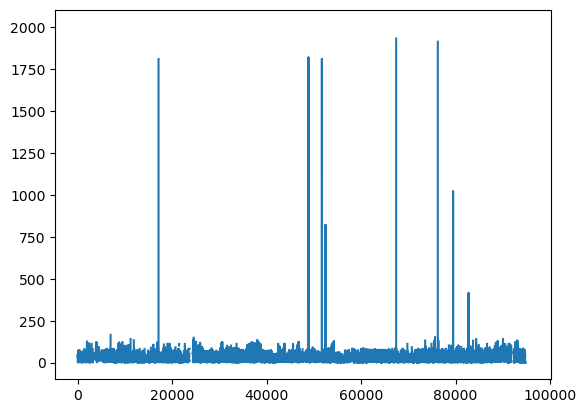

In [529]:
Parcels_2012.bldage.plot()


In [530]:
Parcels_2012=Parcels_2012.merge(valuebygeoid[['GEOID','bk_lvpersqft','bk_perimp','bk_svpersqft','bk_far','bk_hudensity', 'bk_jobdensity']], on="GEOID", how='left').merge(valuebygeoid_age[['GEOID','average_age_n']], on="GEOID", how='left')
Parcels_2012=Parcels_2012.drop_duplicates(subset='APN_2012')
Parcels_2012.shape

(91510, 153)

In [531]:
#Fill null value with zero for additional sqft columns
used_sqft_cols=['BuildingSQFT','AttachGarageSF', 'DetachGarageSF']
Parcels_2012[used_sqft_cols]=Parcels_2012[used_sqft_cols].fillna(0)

#join the data frame for buildings built after 2012 to the parcel layer
Parcels_2012=Parcels_2012.merge(nbld_sqft.rename(columns={'devtype': 'ndevtype', 'BuildingSQFT':'nBuildingSQFT','SF':'nSF_SqFt','MF':'nMF_SqFt','MH':'nMH_SqFt','MF':'nMF_SqFt','ADU':'nADU_SqFt'}),left_on='apn2023', right_on='APN_2023', how='left').copy()


In [532]:
#check parcels with both building before 2012 and after 2012 (note there are not many redevelopment parcels)
Parcels_2012.loc[(Parcels_2012.nBuildingSQFT>0) & (Parcels_2012.Vacancy_x==0) & (Parcels_2012.BuildingSQFT>0) ].groupby(['devtype','ndevtype']).describe()


Imprv_Valu                                          \
                      count           mean            std       min   
devtype ndevtype                                                      
ADU     SF              2.0  122070.500000   59496.671676   80000.0   
IND     IND             1.0       0.000000            NaN       0.0   
        SF              6.0   66134.166667   91269.304179    3666.0   
MF2to4  OTH             1.0       0.000000            NaN       0.0   
MH      ADU             1.0  189486.000000            NaN  189486.0   
        IND             7.0   58372.571429   47382.794475    2567.0   
        MH              5.0   49563.600000   45068.851908       0.0   
        OTH             8.0   67634.875000   40043.262838   13097.0   
        SF             10.0   92415.400000   28064.561957   34199.0   
OTH     IND             2.0  302387.500000  272077.011731  110000.0   
        OTH             6.0   40932.333333   90410.925255       0.0   
        SF              3.0  148814.000000  218093.032250    7608.0   
SF      ADU           107.0  115861.000000  122645.830859       0.0   
        IND            52.0  145533.403846  123483.088940       0.0   
        MH              5.0  140347.600000   49406.401258   94466.0   
        OFC             2.0  436500.000000  263750.829383  250000.0   
        OTH            61.0  132265.967213  104127.809877       0.0   
        SF             50.0  113149.860000  144596.403414       0.0   

                                                           LandValue  \
                        25%       50%        75%       max     count   
devtype ndevtype                                                       
ADU     SF        101035.25  122070.5  143105.75  164141.0       2.0   
IND     IND            0.00       0.0       0.00       0.0       1.0   
        SF         26250.00   35276.5   45929.00  249865.0       6.0   
MF2to4  OTH            0.00       0.0       0.00       0.0       1.0   
MH      ADU       189486.00  189486.0  189486.00  189486.0       1.0   
        IND        25000.00   59859.0   77178.50  141825.0       7.0   
        MH         25000.00   34469.0   73477.00  114872.0       5.0   
        OTH        39266.50   72000.0   88750.00  122592.0       8.0   
        SF         78543.75   95524.5  108250.00  128480.0      10.0   
OTH     IND       206193.75  302387.5  398581.25  494775.0       2.0   
        OTH            0.00    1863.0   13582.50  225000.0       6.0   
        SF         23221.00   38834.0  219417.00  400000.0       3.0   
SF      ADU            0.00   95000.0  180303.00  532147.0     107.0   
        IND        88475.00  140000.0  188602.50  841372.0      52.0   
        MH        120000.00  122667.0  141000.00  223605.0       5.0   
        OFC       343250.00  436500.0  529750.00  623000.0       2.0   
        OTH        50000.00  113397.0  180000.00  450000.0      61.0   
        SF         16242.75   65837.0  156329.50  804113.0      50.0   

                                 ... nSF_SqFt         nBuildingSQFT  \
                           mean  ...      75%     max         count   
devtype ndevtype                 ...                                  
ADU     SF        123728.500000  ...  4150.50  4969.0           2.0   
IND     IND       122362.000000  ...     0.00     0.0           1.0   
        SF         44377.833333  ...  2795.75  3264.0           6.0   
MF2to4  OTH        47041.000000  ...     0.00     0.0           1.0   
MH      ADU        22915.000000  ...     0.00     0.0           1.0   
        IND        51720.142857  ...     0.00     0.0           7.0   
        MH         78541.000000  ...     0.00     0.0           5.0   
        OTH        73108.625000  ...     0.00     0.0           8.0   
        SF         51247.700000  ...  1896.75  3786.0          10.0   
OTH     IND       101727.500000  ...     0.00     0.0           2.0   
        OTH       156129.333333  ...     0.00     0.0           6.0   
        SF        

In [533]:
#create redevelopment indicators (since there are not a lot of records, no model was estimated for redevelopment)
Parcels_2012.loc[(Parcels_2012.nBuildingSQFT>0) & (Parcels_2012.Vacancy_x==0) & (Parcels_2012.BuildingSQFT>0)  & (Parcels_2012.devtype.isin(['SF','ADU'])) & (Parcels_2012.ndevtype=='SF'), 'redev_sf_sf' ]=1
Parcels_2012.loc[(Parcels_2012.nBuildingSQFT>0) & (Parcels_2012.Vacancy_x==0) & (Parcels_2012.BuildingSQFT>0)  & (Parcels_2012.devtype=='SF') & (Parcels_2012.ndevtype=='ADU'), 'redev_sf_adu' ]=1
Parcels_2012.loc[(Parcels_2012.nBuildingSQFT>0) & (Parcels_2012.Vacancy_x==0) & (Parcels_2012.BuildingSQFT>0)  & (Parcels_2012.devtype=='SF') & (Parcels_2012.ndevtype=='MH'), 'redev_sf_mh' ]=1
Parcels_2012.loc[(Parcels_2012.nBuildingSQFT>0) & (Parcels_2012.Vacancy_x==0) & (Parcels_2012.BuildingSQFT>0)  & (Parcels_2012.devtype=='MH') & (Parcels_2012.ndevtype=='SF'), 'redev_mh_sf' ]=1


In [534]:
#Drop columns no longer needed
Parcels_2012.drop(columns=['APN_2023','bltbefore2012'])

,APN_2012,Own_Class,Imprv_Valu,LandValue,TotalValue,ExUseCode,ExUseDesc,Vacancy_x,geometry,calarea,...,nMH_SqFt,OFC,OTH,nSF_SqFt,ndevtype,nBuildingSQFT,redev_sf_sf,redev_sf_adu,redev_sf_mh,redev_mh_sf
0,085240033000,Private,0,11995.0,11995.0,6002.0,VACANT,1,"MULTIPOLYGON (((-196190.706 312664.109, -19618...",31851.432328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,083270001000,Private,10000,25000.0,35000.0,1003.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-201234.468 321394.158, -20124...",994.317952,...,0.0,0.0,0.0,1317.0,SF,1317.0,NaN,NaN,NaN,NaN
2,083270002000,Private,65723,25364.0,91087.0,1099.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-201245.309 321372.295, -20125...",937.966863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,083270003000,Private,47782,16168.0,63950.0,7101.0,RECREATIONAL,0,"MULTIPOLYGON (((-201255.601 321351.538, -20126...",923.665365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,083270004000,Private,90000,30000.0,120000.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-201265.893 321330.781, -20127...",909.372954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91505,202780001000,Municipal,0,0.0,0.0,9108.0,GOVERNMENT,0,"MULTIPOLYGON (((-194339.769 271628.870, -19434...",951.857674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91506,202790023000,Private,302259,75564.0,377823.0,6103.0,MISCELLANEOUS,0,"MULTIPOLYGON (((-196670.419 272426.926, -19672...",6694.869251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91507,116260063000,Unknown,0,0.0,0.0,0.0,,0,"MULTIPOLYGON (((-199217.623 291230.336, -19921...",203.278583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91508,116260061000,Unknown,0,0.0,0.0,0.0,,0,"MULTIPOLYGON (((-199231.651 291228.077, -19922...",1352.300708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [535]:
#Set parcel capacity to the bigger  of Resid_Dens from zoning and general plan or the current dwelling units per acre information
Parcels_2012['DUA']=Parcels_2012['TOT_DU']*43560.0/Parcels_2012['sqft_p']
Parcels_2012['Cap_HS']=Parcels_2012['DUA']
Parcels_2012.loc[Parcels_2012.Resid_Dens>Parcels_2012.DUA,'Cap_HS']=Parcels_2012.loc[Parcels_2012.Resid_Dens>Parcels_2012.DUA,'Resid_Dens']
Parcels_2012.loc[Parcels_2012.DUA<Parcels_2012.Cap_HS,['DUA','Cap_HS','Resid_Dens']]

,DUA,Cap_HS,Resid_Dens
19,0.000000,1.00,1.00
20,0.000000,1.00,1.00
21,0.398115,1.00,1.00
22,0.137930,0.33,0.33
23,0.090328,0.33,0.33
...,...,...,...
91500,0.000000,3.00,3.00
91506,0.368559,4.00,4.00
91507,0.000000,3.00,3.00
91508,0.000000,3.00,3.00


In [536]:
Parcels_2012.loc[Parcels_2012.Cap_HS>50,['TOT_DU', 'sqft_p']]

,TOT_DU,sqft_p
1951,1.0,703.0
1959,1.0,409.0
2297,18.0,7894.0
2577,2.0,1220.0
19302,3.0,702.0
...,...,...
84268,4.0,3201.0
84420,4.0,3266.0
84421,4.0,3283.0
84444,4.0,3207.0


In [537]:
Parcels_2012['neighbors_jobdensity'].max()

538.2833650697537

In [538]:
Parcels_2012.columns[-90:-50]

Index(['stop_025mi', 'stop_050mi', 'NatWalkInd', 'job_auto45', 'wrk_auto45',
       'job_tran45', 'wrk_tran45', 'lat_rad', 'lon_rad', 'neighbors_hudensity',
       'neighbors_jobdensity', 'neighbors_per_empedu_p',
       'neighbors_per_empfoo_p', 'neighbors_per_empgov_p',
       'neighbors_per_empind_p', 'neighbors_per_empmed_p',
       'neighbors_per_empofc_p', 'neighbors_per_empret_p',
       'neighbors_per_empsvc_p', 'neighbors_per_empoth_p',
       'neighbors_per_emp_entropy', 'neighbors_hhvshu', 'neighbors_per_sf',
       'neighbors_per_blt', 'neighbors_jobentropy', 'dist2waterpipe_n',
       'cnt_intersections_n', 'neighbors_hudensity_n',
       'neighbors_jobdensity_n', 'apn2012', 'apn2023', 'devtype',
       'BuildingSQFT', 'SqFt_ADU', 'SqFt_APT', 'SqFt_COM', 'SqFt_IND',
       'SqFt_MF2to4', 'SqFt_MH', 'SqFt_OFC'],
      dtype='object')

In [539]:
#Check the list of potential features and drop those with less than 1% of variance, 'dist2waterpipe_n',
#sel_variables=['inWaterDistrictP', 'cnt_intersections_n', 'inSGA',  'inPSGA',  'is_MPO',  'is_TMA',  'hu_density',  'pop_density',  'job_density',  'jph_balance',  'emp_entropy',  'mix_entropy',
# 'wrkperjob',  'design',  'stop_025mi',  'stop_050mi',  'NatWalkInd',  'job_auto45',  'wrk_auto45',  'job_tran45',  'wrk_tran45', 'bk_far', 'bk_hudensity','bk_jobdensity','average_age_n',
#   'neighbors_hudensity_n', 'neighbors_jobdensity_n',   'neighbors_per_sf', 'neighbors_per_empret_p', 'neighbors_hhvshu',  'neighbors_per_blt', 'neighbors_jobentropy', 'Acres10p', 'Acres1to10', 'Acreshalfto1acres', 'Acresquartertohalfacres', 'Acreslt4000sqft']
sel_variables=['inWaterDistrictP', 'cnt_intersections_n', 'inSGA',  'inPSGA',  'bk_far', 'bk_hudensity','bk_jobdensity','average_age_n',
   'neighbors_hudensity_n', 'neighbors_jobdensity_n',   'neighbors_per_sf', 'neighbors_per_empret_p', 'neighbors_hhvshu',  'neighbors_per_blt', 'neighbors_jobentropy', 'Acres10p', 'Acres1to10', 'Acreshalfto1acres', 'Acresquartertohalfacres', 'Acreslt4000sqft']
#drop columns with less than 1% variance

variance =Parcels_2012[sel_variables].replace([np.inf, -np.inf,np.nan], 0).var()


X_cols_n = [ ]

for i in range(0,len(variance)):
    if variance.iloc[i]>=0.01: #setting the threshold as 1%
        X_cols_n.append(sel_variables[i])
X_cols_n

['inWaterDistrictP',
 'cnt_intersections_n',
 'inSGA',
 'inPSGA',
 'bk_hudensity',
 'bk_jobdensity',
 'average_age_n',
 'neighbors_hudensity_n',
 'neighbors_jobdensity_n',
 'neighbors_per_sf',
 'neighbors_per_empret_p',
 'neighbors_hhvshu',
 'neighbors_per_blt',
 'neighbors_jobentropy',
 'Acres10p',
 'Acres1to10',
 'Acreshalfto1acres',
 'Acresquartertohalfacres',
 'Acreslt4000sqft']

In [540]:
variance.loc[variance<0.01]

bk_far    0.00456
dtype: float64

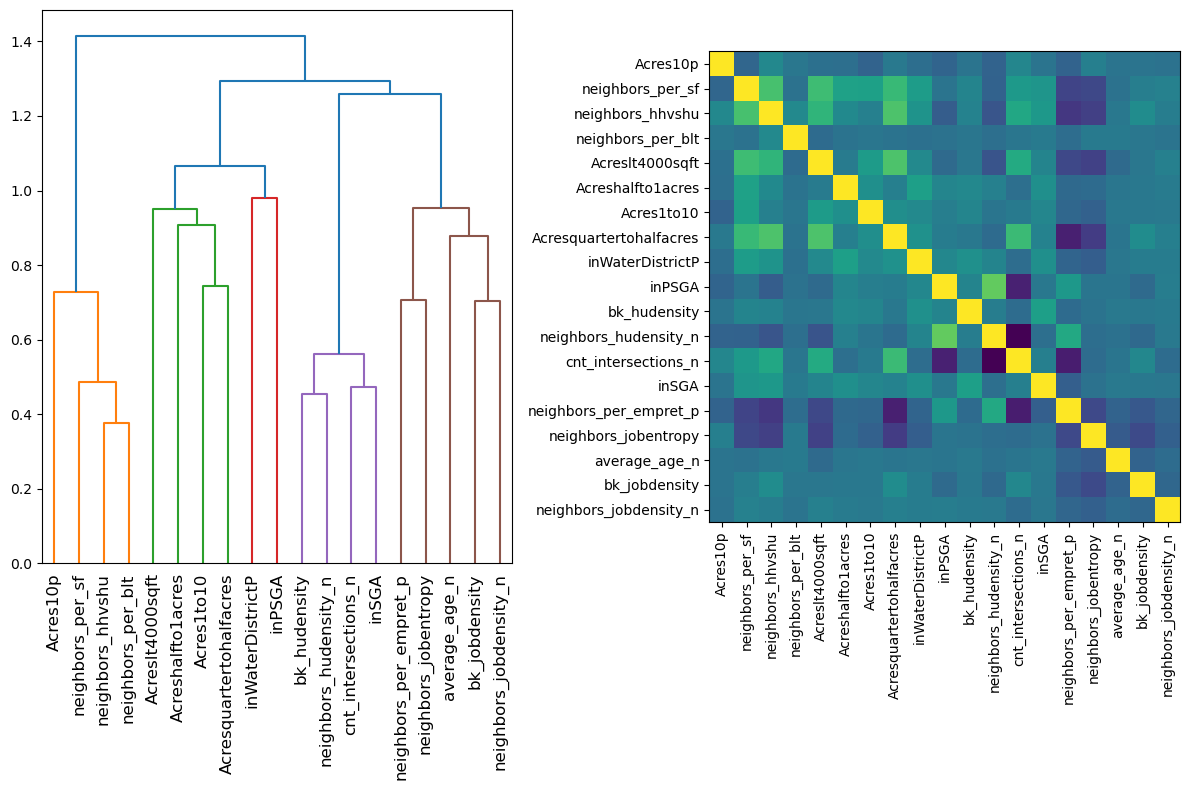

In [541]:
#Remove highly correlated features
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

corr=Parcels_2012[X_cols_n].corr()

corr_triu=corr.where(~np.tril(np.ones(corr.shape)).astype(bool))
to_drop = [col for col in corr_triu.columns if any(corr_triu[col].abs() > 0.7)]
sel_variables=[c for c in X_cols_n if c not in to_drop]

# feature selection
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8)) 

#create corr matrix between all possible columns
# Ensure the correlation matrix is symmetric
corr=Parcels_2012[sel_variables].corr()
corr=np.asmatrix(corr.to_numpy())
corr = (corr + corr.T) / 2
#np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)


dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=sel_variables, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

try:
  ax2.imshow(corr[dendro_idx, :][:, dendro_idx])
  ax2.set_xticks(dendro_idx)
  ax2.set_yticks(dendro_idx)
except Exception:
  # Handle potential MultiIndex indexing error here
  pass  # Replace with appropriate error handling
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [542]:
exludeTypes=['GOVERNMENT', 'MINI MART', 'UTILITY', 'COMMERCIAL', 'RESTAURANT',
       'RETAIL SALES', 'RESID. HOTEL/MOTEL/RESORTS', 'SCHOOLS',
       'AUTOMOTIVE USES', 'TIMBER PRESERVE',
       'AGRICULTURAL', 
       'GROCERY STORE', 'INDUSTRIAL', 'MEDICAL/DENTAL/LABS', 'TIMBER',
      'OFFICE', 'HOSPITAL',  'PARKING LOT']

def get_alternative_parcels(df, developed_parcel, num_samples):
    alternatives = df[(df.APN_2012 != developed_parcel) &  ((df.BuildingSQFT==0)| (df.BuildingSQFT.isnull()) | (df.Vacancy_x==1)) & ~(df.ExUseDesc.isin(exludeTypes)) &(df.devstatus!='Undevelopable')]
    return alternatives.sample(num_samples, replace=True)

# Function to create dataframe with developed and alternative parcels
def create_choice_data(df, num_samples):
    choice_data = []
    for index, row in df.loc[(df.apn2023.isin(nbld_sqft.loc[nbld_sqft.BuildingSQFT>0].APN_2023.unique())) & (df.Vacancy_x==1)].iterrows():
        #print(index)
        developed_parcel = row["APN_2012"]
        alternative_parcels = get_alternative_parcels(df.copy(), developed_parcel, num_samples)
        #print(alternative_parcels.shape)
        #alternative_parcels = get_undeveloped_parcels(df.copy(), num_samples)
        alternative_data = alternative_parcels.to_dict(orient="records")
        for alt_parcel in alternative_data:
            alt_parcel["choice"] = developed_parcel  # Developed parcel is the choice for alternatives
            choice_data.append(alt_parcel)
    return pd.DataFrame(choice_data)

# Get choice data with developed and 29 alternative parcels for each
df_choice = create_choice_data(Parcels_2012, num_samples=29)
df_choice

,APN_2012,Own_Class,Imprv_Valu,LandValue,TotalValue,ExUseCode,ExUseDesc,Vacancy_x,geometry,calarea,...,nSF_SqFt,ndevtype,nBuildingSQFT,redev_sf_sf,redev_sf_adu,redev_sf_mh,redev_mh_sf,DUA,Cap_HS,choice
0,041420003000,Private,0,136016.0,136016.0,6003.0,VACANT,1,MULTIPOLYGON (((-212112.66654942083 283606.489...,184719.911610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,085320066000
1,110380012000,Private,0,42252.0,42252.0,1.0,VACANT,1,MULTIPOLYGON (((-195985.37875796063 284381.886...,1352.222469,...,1971.0,SF,1971.0,NaN,NaN,NaN,NaN,0.000000,3.500000,085320066000
2,048210045000,Private,0,30000.0,30000.0,1.0,VACANT,1,MULTIPOLYGON (((-201694.43763643803 283433.075...,2552.683485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.000000,085320066000
3,016600015000,Private,0,18083.0,18083.0,6002.0,VACANT,1,MULTIPOLYGON (((-112806.54714268993 347575.194...,15903.685779,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,085320066000
4,051060004000,Private,0,83229.0,83229.0,2101.0,VACANT,1,MULTIPOLYGON (((-200940.39631300894 278163.338...,4262.766198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,085320066000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33751,107390012000,Private,0,29399.0,115253.0,1601.0,RESID. CONDOMINIUM,0,MULTIPOLYGON (((-200039.77898460976 287373.591...,166.285565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.348798,24.348798,091340014000
33752,101420025000,Unknown,0,0.0,0.0,0.0,,0,MULTIPOLYGON (((-202297.886067644 288547.52236...,1290.629465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.570522,20.000000,091340014000
33753,060410012000,Private,0,18079.0,18079.0,6001.0,VACANT,1,MULTIPOLYGON (((-186155.7768195958 281367.4092...,159704.112331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.330000,091340014000
33754,090470013000,Private,0,24921.0,24921.0,6002.0,VACANT,1,MULTIPOLYGON (((-190733.9874942936 267736.0536...,19264.271958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.330000,091340014000


In [543]:
#get parcels developed since 2012; these are the chosen choice
developed_parcels=Parcels_2012.loc[Parcels_2012.apn2023.isin(nbld_sqft.loc[nbld_sqft.BuildingSQFT>0].APN_2023.unique())].copy()
developed_parcels['choice']=developed_parcels['APN_2012']
developed_parcels['chosen']=1

#set indicator chosen to 0 for the other 29 alternatives and combine both chosen and unchosen alternatives together
df_choice['chosen']=0
all_alternatives=pd.concat([developed_parcels,df_choice])
all_alternatives

,APN_2012,Own_Class,Imprv_Valu,LandValue,TotalValue,ExUseCode,ExUseDesc,Vacancy_x,geometry,calarea,...,ndevtype,nBuildingSQFT,redev_sf_sf,redev_sf_adu,redev_sf_mh,redev_mh_sf,DUA,Cap_HS,choice,chosen
1,083270001000,Private,10000,25000.0,35000.0,1003.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-201234.468 321394.158, -20124...",994.317952,...,SF,1317.0,NaN,NaN,NaN,NaN,8.145863,8.145863,083270001000,1
22,019420043000,Private,120000,35000.0,155000.0,6103.0,MISCELLANEOUS,0,"MULTIPOLYGON (((-205907.423 331973.312, -20611...",32344.757968,...,SF,1297.0,NaN,NaN,NaN,NaN,0.137930,0.330000,019420043000,1
126,085320066000,Private,15000,100000.0,115000.0,6002.0,VACANT,1,"MULTIPOLYGON (((-197715.712 311558.661, -19770...",20086.755180,...,SF,2258.0,NaN,NaN,NaN,NaN,0.000000,0.000000,085320066000,1
253,083300040000,Private,35279,30576.0,65855.0,1099.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-201477.848 321481.962, -20148...",1138.827242,...,MH,1110.0,NaN,NaN,NaN,NaN,7.112417,7.112417,083300040000,1
260,083340003000,Private,10000,35000.0,45000.0,6101.0,RESIDENTIAL,0,"MULTIPOLYGON (((-200724.796 322246.563, -20078...",2920.252797,...,MH,976.0,NaN,NaN,NaN,NaN,1.386864,1.386864,083340003000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33751,107390012000,Private,0,29399.0,115253.0,1601.0,RESID. CONDOMINIUM,0,"MULTIPOLYGON (((-200039.779 287373.591, -20004...",166.285565,...,NaN,NaN,NaN,NaN,NaN,NaN,24.348798,24.348798,091340014000,0
33752,101420025000,Unknown,0,0.0,0.0,0.0,,0,"MULTIPOLYGON (((-202297.886 288547.522, -20233...",1290.629465,...,NaN,NaN,NaN,NaN,NaN,NaN,12.570522,20.000000,091340014000,0
33753,060410012000,Private,0,18079.0,18079.0,6001.0,VACANT,1,"MULTIPOLYGON (((-186155.777 281367.409, -18632...",159704.112331,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.330000,091340014000,0
33754,090470013000,Private,0,24921.0,24921.0,6002.0,VACANT,1,"MULTIPOLYGON (((-190733.987 267736.054, -19080...",19264.271958,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.330000,091340014000,0


In [544]:
#set individual id to the chosen parcel's APN for all 30 alternatives, each id represents one individual development project
all_alternatives['ID']=pd.factorize(all_alternatives['choice'])[0]+1

#set alternative id for each of 30 alternatives associated with each individual development
all_alternatives['Alt_ID'] = all_alternatives.groupby('choice')['APN_2012'].rank(ascending=False, method='first').astype(int)
all_alternatives['Alt_Name']=all_alternatives['Alt_ID'].map(lambda x: str(x)+'ALt')
all_alternatives.sort_values(by=['ID','Alt_ID']) 

,APN_2012,Own_Class,Imprv_Valu,LandValue,TotalValue,ExUseCode,ExUseDesc,Vacancy_x,geometry,calarea,...,redev_sf_adu,redev_sf_mh,redev_mh_sf,DUA,Cap_HS,choice,chosen,ID,Alt_ID,Alt_Name
1,083270001000,Private,10000,25000.0,35000.0,1003.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-201234.468 321394.158, -20124...",994.317952,...,NaN,NaN,NaN,8.145863,8.145863,083270001000,1,1,1,1ALt
22,019420043000,Private,120000,35000.0,155000.0,6103.0,MISCELLANEOUS,0,"MULTIPOLYGON (((-205907.423 331973.312, -20611...",32344.757968,...,NaN,NaN,NaN,0.137930,0.330000,019420043000,1,2,1,1ALt
6,305310003000,Private,160000,80000.0,240000.0,6103.0,MISCELLANEOUS,0,"MULTIPOLYGON (((-189043.811 294010.064, -18909...",22423.284257,...,NaN,NaN,NaN,0.190046,1.000000,085320066000,0,3,1,1ALt
23,305100010000,Private,0,9297.0,9297.0,6002.0,VACANT,1,"MULTIPOLYGON (((-190662.704 298429.571, -19067...",12035.477200,...,NaN,NaN,NaN,0.000000,1.000000,085320066000,0,3,2,2ALt
21,206210027000,Private,4882,5661.0,10543.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-204276.493 272362.411, -20430...",1247.924226,...,NaN,NaN,NaN,7.484536,7.484536,085320066000,0,3,3,3ALt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90830,201910033000,Private,0,26000.0,26000.0,1500.0,RESID. MULTIPLE FAMILY,0,"MULTIPOLYGON (((-193781.138 272735.383, -19380...",1045.897400,...,NaN,NaN,NaN,0.000000,8.000000,201910033000,1,2786,1,1ALt
90835,201910037000,Private,0,30000.0,30000.0,1500.0,RESID. MULTIPLE FAMILY,0,"MULTIPOLYGON (((-193856.005 272814.037, -19382...",1044.680981,...,NaN,NaN,NaN,0.000000,8.000000,201910037000,1,2787,1,1ALt
90836,201910038000,Private,0,30000.0,30000.0,1500.0,RESID. MULTIPLE FAMILY,0,"MULTIPOLYGON (((-193808.799 272803.908, -19382...",1033.361816,...,NaN,NaN,NaN,0.000000,8.000000,201910038000,1,2788,1,1ALt
90837,201910039000,Private,0,30000.0,30000.0,1500.0,RESID. MULTIPLE FAMILY,0,"MULTIPOLYGON (((-193819.742 272851.094, -19380...",1049.337234,...,NaN,NaN,NaN,0.000000,8.000000,201910039000,1,2789,1,1ALt


chosen
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: cnt_intersections, dtype: object

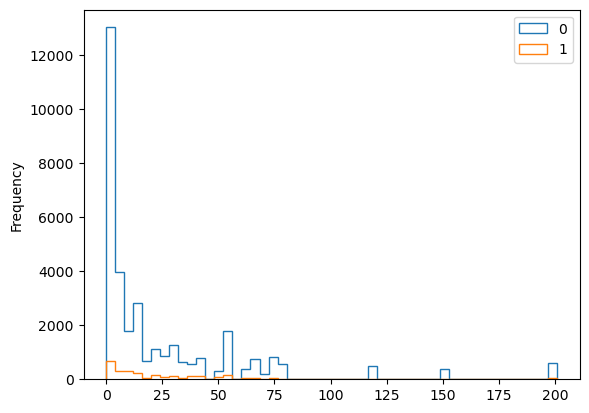

In [545]:
all_alternatives.groupby('chosen')['cnt_intersections'].plot(kind='hist', bins=50, log=False, 
                                                         histtype='step', legend=True)

In [546]:
df_w=all_alternatives.pivot(index='ID', columns='Alt_ID', values=sel_variables+['choice','chosen'])
df_w.columns=[f'{col[0]}_{col[1]}' for col in df_w.columns]
df_w.reset_index(inplace=True)
df_w['choice']=df_w[[f'chosen_{c}' for c in range(1,31)]].idxmax(axis=1).map(lambda x: int(x.split('_')[1]))
df_w['APN_2012']=df_w['choice_1']
df_w.drop(columns=['choice_'+str(i) for i in range(1,31)], inplace=True)
df_w.drop(columns=[f'chosen_{c}' for c in range(1,31)], inplace=True)

In [547]:
df_w.columns[df_w.dtypes=='object']

Index(['inWaterDistrictP_1', 'inWaterDistrictP_2', 'inWaterDistrictP_3',
       'inWaterDistrictP_4', 'inWaterDistrictP_5', 'inWaterDistrictP_6',
       'inWaterDistrictP_7', 'inWaterDistrictP_8', 'inWaterDistrictP_9',
       'inWaterDistrictP_10',
       ...
       'Acreslt4000sqft_22', 'Acreslt4000sqft_23', 'Acreslt4000sqft_24',
       'Acreslt4000sqft_25', 'Acreslt4000sqft_26', 'Acreslt4000sqft_27',
       'Acreslt4000sqft_28', 'Acreslt4000sqft_29', 'Acreslt4000sqft_30',
       'APN_2012'],
      dtype='object', length=571)

In [548]:
#after pivot numeric columns are turned into text type, convert those back to numeric
df_w[df_w.columns[df_w.dtypes=='object'][:-1]]=df_w[df_w.columns[df_w.dtypes=='object'][:-1]].apply(pd.to_numeric, errors='coerce')
df_w.set_index('APN_2012')

,ID,inWaterDistrictP_1,inWaterDistrictP_2,inWaterDistrictP_3,inWaterDistrictP_4,inWaterDistrictP_5,inWaterDistrictP_6,inWaterDistrictP_7,inWaterDistrictP_8,inWaterDistrictP_9,...,Acreslt4000sqft_22,Acreslt4000sqft_23,Acreslt4000sqft_24,Acreslt4000sqft_25,Acreslt4000sqft_26,Acreslt4000sqft_27,Acreslt4000sqft_28,Acreslt4000sqft_29,Acreslt4000sqft_30,choice
APN_2012,,,,,,,,,,,,,,,,,,,,,
083270001000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
019420043000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
085320066000,3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
083300040000,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
083340003000,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910033000,2786,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
201910037000,2787,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
201910038000,2788,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [549]:
#create availability columns needed by BIOGEME
ncols_df = pd.DataFrame(index=df_w.index)

ncols=['av_'+str(i) for i in range(1,31)]
for c in ncols:
    ncols_df[c]=1

df_w = pd.concat([df_w, ncols_df], axis=1)

In [550]:
developed_parcels.ndevtype.unique()

array(['SF', 'MH', 'IND', 'ADU', 'OTH', 'OFC', 'MF2to4', 'APT'],
      dtype=object)

In [551]:
#Create 3 different market segmentations  
devtypes={'SF':0,'MH':0,'ADU':0, 'MF2to4':0, 'APT':0, 'IND':1, 'OTH':1, 'OFC':1 }
developed_parcels['DEV2TYPE']=developed_parcels['ndevtype'].map(lambda x: devtypes[x]) 

devtypes={'SF':0,'MH':1,'ADU':0, 'MF2to4':1, 'APT':1, 'IND':2, 'OTH':2, 'OFC':2}
developed_parcels['DEV3TYPE']=developed_parcels['ndevtype'].map(lambda x: devtypes[x])    

devtypes={'SF':0,'MH':1,'ADU':0, 'MF2to4':2, 'APT':2, 'IND':3, 'OTH':3, 'OFC':4}
developed_parcels['DEV5TYPE']=developed_parcels['ndevtype'].map(lambda x: devtypes[x]) 

df_w=df_w.merge(developed_parcels[['APN_2012','DEV2TYPE','DEV3TYPE','DEV5TYPE']], on='APN_2012', how='inner')
df_w

,ID,inWaterDistrictP_1,inWaterDistrictP_2,inWaterDistrictP_3,inWaterDistrictP_4,inWaterDistrictP_5,inWaterDistrictP_6,inWaterDistrictP_7,inWaterDistrictP_8,inWaterDistrictP_9,...,av_24,av_25,av_26,av_27,av_28,av_29,av_30,DEV2TYPE,DEV3TYPE,DEV5TYPE
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,0
1,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,0
2,3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,1,1,1,1,0,0,0
3,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,1,1
4,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2786,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,0
2786,2787,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,0
2787,2788,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,0
2788,2789,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,0


In [552]:
#IDentify characteristic varables
char_columns = df_w.select_dtypes(['object']).columns
char_columns.to_list()

['APN_2012']

In [553]:
#Remove characteristic columns
df_w.drop(columns=char_columns, inplace=True)
df_w.fillna(0, inplace=True)

In [554]:
#import biogeme libraries
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta
from biogeme import database as db
from biogeme.catalog import segmentation_catalogs
from biogeme.results import compile_estimation_results, pareto_optimal

# Define choice variabl
choice_var = "choice"
database=db.Database("resdev_db",df_w)
globals().update(database.variables)
database.variables

{'ID': ID,
 'inWaterDistrictP_1': inWaterDistrictP_1,
 'inWaterDistrictP_2': inWaterDistrictP_2,
 'inWaterDistrictP_3': inWaterDistrictP_3,
 'inWaterDistrictP_4': inWaterDistrictP_4,
 'inWaterDistrictP_5': inWaterDistrictP_5,
 'inWaterDistrictP_6': inWaterDistrictP_6,
 'inWaterDistrictP_7': inWaterDistrictP_7,
 'inWaterDistrictP_8': inWaterDistrictP_8,
 'inWaterDistrictP_9': inWaterDistrictP_9,
 'inWaterDistrictP_10': inWaterDistrictP_10,
 'inWaterDistrictP_11': inWaterDistrictP_11,
 'inWaterDistrictP_12': inWaterDistrictP_12,
 'inWaterDistrictP_13': inWaterDistrictP_13,
 'inWaterDistrictP_14': inWaterDistrictP_14,
 'inWaterDistrictP_15': inWaterDistrictP_15,
 'inWaterDistrictP_16': inWaterDistrictP_16,
 'inWaterDistrictP_17': inWaterDistrictP_17,
 'inWaterDistrictP_18': inWaterDistrictP_18,
 'inWaterDistrictP_19': inWaterDistrictP_19,
 'inWaterDistrictP_20': inWaterDistrictP_20,
 'inWaterDistrictP_21': inWaterDistrictP_21,
 'inWaterDistrictP_22': inWaterDistrictP_22,
 'inWaterDistrict

In [555]:
#define beta to be estimated for utility funciton
#restrict minimum of parameters to zero
for c in sel_variables:
    expr="B_"+c+"= Beta('B_"+c+"',0,None,None,0)"
    #print(expr)
    exec(expr)
    #expr="(B_"+c+"_catalog,)=  segmentation_catalogs(generic_name='B_"+c+"', beta_parameters=[B_"+c+"], potential_segmentations=(segmentation_devtype, ),  maximum_number=1,)"
    #print(expr)
    #exec(expr)

for i in range(1,31):
    #betasMultiVar=["B_"+c+"_catalog*"+c+"_"+str(i) for c in sel_variables]
    betasMultiVar=["B_"+c+"*"+c+"_"+str(i) for c in sel_variables]
    expr="V"+str(i)+"="+"+".join(betasMultiVar)
    #print(expr)
    exec(expr)

V={}
for i in range(1,31):
    expr="V["+str(i)+"]=V"+str(i)
    exec(expr)
    
av={i:eval('av_'+str(i)) for i in range(1,31)}
logprob=models.loglogit(V,av,choice)
mybiogeme=bio.BIOGEME(database, logprob)
mybiogeme.modelName='trpadev_logit'

results=mybiogeme.estimate()
#results=mybiogeme.estimate_catalog()
print(results.shortSummary())

# Get the results in a pandas table
pandas_results = results.getEstimatedParameters()
print(pandas_results)

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model trpadev_logit
Nbr of parameters:		19
Sample size:			2790
Excluded data:			0
Final log likelihood:		-4880.318
Akaike Information Criterion:	9798.637
Bayesian Information Criterion:	9911.379

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                -0.447435      0.122425    -3.654777  2.574055e-04
B_Acres1to10               0.110213      0.094434     1.167092  2.431733e-01
B_Acreshalfto1acres       -0.021459      0.121409    -0.176752  8.597035e-01
B_Acreslt4000sqft         -1.430875      0.209067    -6.844082  7.696732e-12
B_Acresquartertohalfacres  0.363523      0.104288     3.485752  4.907562e-04
B_average_age_n            0.115628      0.247037     0.468060  6.397418e-01
B_bk_hudensity            -0.046156      0.014255    -3.237924  1.204028e-03
B_bk_jobdensity           -0.034867      0.013215    -2.638524  8.326785e-03
B_cnt_intersections_n      1.387941      0.161447     8.596905  0.000000e+00
B_inPSGA              

In [556]:
best_acc=0
nulllog=mybiogeme.calculateNullLoglikelihood ( av )
#define beta to be estimated for utility funciton

    
#restrict minimum of parameters to zero
for c in sel_variables:
    expr="B_"+c+"= Beta('B_"+c+"',0,None,None,0)"
    #print(expr)
    exec(expr)
    
while len(sel_variables)>0:
    for i in range(1,31):
        betasMultiVar=["B_"+c+"*"+c+"_"+str(i) for c in sel_variables]
        expr="V"+str(i)+"="+"+".join(betasMultiVar)
        #print(expr)
        exec(expr)

    V={}
    for i in range(1,31):
        expr="V["+str(i)+"]=V"+str(i)
        exec(expr)
    
    av={i:eval('av_'+str(i)) for i in range(1,31)}
    logprob=models.loglogit(V,av,choice)
    mybiogeme=bio.BIOGEME(database, logprob)
    mybiogeme.modelName='resdev_logit'

    results=mybiogeme.estimate()
    print(results.shortSummary())

    # Get the results in a pandas table
    pandas_results = results.getEstimatedParameters()
    print(pandas_results)
    
    stats = results.getGeneralStatistics()
    cur_acc=1-(stats['Final log likelihood'].value-len(sel_variables))/nulllog
    print(cur_acc)
    if cur_acc<best_acc:
        break
    else:
        best_acc=cur_acc
    worst_p=pandas_results['Rob. p-value'].idxmax()
    sel_variables.remove(worst_p[2:])
    print(sel_variables)

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		19
Sample size:			2790
Excluded data:			0
Final log likelihood:		-4880.318
Akaike Information Criterion:	9798.637
Bayesian Information Criterion:	9911.379

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                -0.447450      0.122425    -3.654892  2.572899e-04
B_Acres1to10               0.110204      0.094434     1.166997  2.432117e-01
B_Acreshalfto1acres       -0.021466      0.121409    -0.176804  8.596621e-01
B_Acreslt4000sqft         -1.430899      0.209070    -6.844108  7.695400e-12
B_Acresquartertohalfacres  0.363518      0.104288     3.485703  4.908449e-04
B_average_age_n            0.115589      0.247037     0.467901  6.398554e-01
B_bk_hudensity            -0.046156      0.014255    -3.237917  1.204056e-03
B_bk_jobdensity           -0.034867      0.013215    -2.638536  8.326483e-03
B_cnt_intersections_n      1.387966      0.161447     8.597058  0.000000e+00
B_inPSGA               

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		18
Sample size:			2790
Excluded data:			0
Final log likelihood:		-4880.32
Akaike Information Criterion:	9796.639
Bayesian Information Criterion:	9903.448

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                -0.448439      0.119142    -3.763890  1.672907e-04
B_Acres1to10               0.109195      0.089784     1.216199  2.239093e-01
B_Acreshalfto1acres       -0.022152      0.119306    -0.185672  8.527020e-01
B_Acreslt4000sqft         -1.431624      0.206844    -6.921276  4.475975e-12
B_Acresquartertohalfacres  0.363005      0.102429     3.543965  3.941581e-04
B_average_age_n            0.115316      0.247301     0.466301  6.410003e-01
B_bk_hudensity            -0.046244      0.014122    -3.274573  1.058218e-03
B_bk_jobdensity           -0.034900      0.013173    -2.649418  8.063050e-03
B_cnt_intersections_n      1.387588      0.161224     8.606567  0.000000e+00
B_inPSGA                

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		17
Sample size:			2790
Excluded data:			0
Final log likelihood:		-4880.323
Akaike Information Criterion:	9794.646
Bayesian Information Criterion:	9895.521

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                -0.448549      0.119092    -3.766424  1.656025e-04
B_Acres1to10               0.108976      0.089641     1.215697  2.241004e-01
B_Acreshalfto1acres       -0.022478      0.119204    -0.188568  8.504313e-01
B_Acreslt4000sqft         -1.431854      0.206780    -6.924516  4.374723e-12
B_Acresquartertohalfacres  0.362815      0.102333     3.545424  3.919820e-04
B_average_age_n            0.114062      0.247536     0.460789  6.449502e-01
B_bk_hudensity            -0.046238      0.014117    -3.275240  1.055722e-03
B_bk_jobdensity           -0.034970      0.013159    -2.657504  7.872163e-03
B_cnt_intersections_n      1.387445      0.161363     8.598312  0.000000e+00
B_inPSGA               

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		16
Sample size:			2790
Excluded data:			0
Final log likelihood:		-4880.339
Akaike Information Criterion:	9792.678
Bayesian Information Criterion:	9887.618

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                -0.441227      0.107963    -4.086839  4.372911e-05
B_Acres1to10               0.115553      0.076248     1.515497  1.296466e-01
B_Acreslt4000sqft         -1.426919      0.201784    -7.071521  1.532552e-12
B_Acresquartertohalfacres  0.368266      0.092248     3.992135  6.548113e-05
B_average_age_n            0.110228      0.247557     0.445264  6.561293e-01
B_bk_hudensity            -0.045768      0.013761    -3.326028  8.809323e-04
B_bk_jobdensity           -0.034980      0.013175    -2.655012  7.930558e-03
B_cnt_intersections_n      1.388879      0.161349     8.607924  0.000000e+00
B_inPSGA                  -0.844626      0.129048    -6.545025  5.948553e-11
B_inSGA                

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		15
Sample size:			2790
Excluded data:			0
Final log likelihood:		-4880.425
Akaike Information Criterion:	9790.851
Bayesian Information Criterion:	9879.858

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                -0.441102      0.108070    -4.081616  4.472374e-05
B_Acres1to10               0.117304      0.076774     1.527912  1.265343e-01
B_Acreslt4000sqft         -1.426261      0.201847    -7.066035  1.594280e-12
B_Acresquartertohalfacres  0.369883      0.092512     3.998220  6.382061e-05
B_bk_hudensity            -0.044327      0.014061    -3.152534  1.618597e-03
B_bk_jobdensity           -0.034826      0.013064    -2.665717  7.682442e-03
B_cnt_intersections_n      1.400381      0.159897     8.758046  0.000000e+00
B_inPSGA                  -0.843319      0.129508    -6.511727  7.429168e-11
B_inSGA                    1.977264      0.085136    23.224797  0.000000e+00
B_inWaterDistrictP     

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		14
Sample size:			2790
Excluded data:			0
Final log likelihood:		-4881.451
Akaike Information Criterion:	9790.902
Bayesian Information Criterion:	9873.975

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                -0.545040      0.086219    -6.321587  2.588902e-10
B_Acreslt4000sqft         -1.473825      0.194349    -7.583393  3.375078e-14
B_Acresquartertohalfacres  0.317979      0.078529     4.049183  5.139683e-05
B_bk_hudensity            -0.047702      0.013871    -3.438923  5.840328e-04
B_bk_jobdensity           -0.034897      0.012978    -2.688907  7.168630e-03
B_cnt_intersections_n      1.397448      0.160490     8.707406  0.000000e+00
B_inPSGA                  -0.847174      0.129830    -6.525238  6.789391e-11
B_inSGA                    1.974592      0.085470    23.102655  0.000000e+00
B_inWaterDistrictP         0.181062      0.085320     2.122144  3.382561e-02
B_neighbors_hhvshu     

In [557]:
nulllog=mybiogeme.calculateNullLoglikelihood ( av )
modified_Rho_Sq=1-(stats['Final log likelihood'].value-len(sel_variables))/nulllog
modified_Rho_Sq

0.48411051501551416

In [558]:
pandas_results['fields']=pandas_results.index
pandas_results.to_csv(r'.\development_model.csv', index=False)
pandas_results

,Value,Rob. Std err,Rob. t-test,Rob. p-value,fields
B_Acres10p,-0.545040,0.086219,-6.321587,2.588902e-10,B_Acres10p
B_Acreslt4000sqft,-1.473825,0.194349,-7.583393,3.375078e-14,B_Acreslt4000sqft
B_Acresquartertohalfacres,0.317979,0.078529,4.049183,5.139683e-05,B_Acresquartertohalfacres
B_bk_hudensity,-0.047702,0.013871,-3.438923,5.840328e-04,B_bk_hudensity
B_bk_jobdensity,-0.034897,0.012978,-2.688907,7.168630e-03,B_bk_jobdensity
B_cnt_intersections_n,1.397448,0.160490,8.707406,0.000000e+00,B_cnt_intersections_n
B_inPSGA,-0.847174,0.129830,-6.525238,6.789391e-11,B_inPSGA
B_inSGA,1.974592,0.085470,23.102655,0.000000e+00,B_inSGA
B_inWaterDistrictP,0.181062,0.085320,2.122144,3.382561e-02,B_inWaterDistrictP
B_neighbors_hhvshu,2.094618,0.106574,19.654109,0.000000e+00,B_neighbors_hhvshu


In [559]:
sel_variables=[c[2:] for c in pandas_results.loc[pandas_results.Value!=0].index]

#sel_variables_1=[]
#sel_variables_2=[c for c in sel_variables if c not in sel_variables_1]

segmentation_dev2types = database.generate_segmentation(
    variable='DEV2TYPE', mapping={0: 'RES', 1: 'NR'}
)

segmentation_dev3types = database.generate_segmentation(
    variable='DEV3TYPE', mapping={0: 'SF', 1: 'MF', 2: 'NR'}
)


#define beta to be estimated for utility funciton
#restrict minimum of parameters to zero
for c in sel_variables:
    expr="B_"+c+"= Beta('B_"+c+"',0,None,None,0)"
    #print(expr)
    exec(expr)


#define catalog for market segmentations to be analyzed
#expr="("+",".join(["B_"+c+"_catalog" for c in sel_variables_2])+")=segmentation_catalogs(generic_name='B_catalog', beta_parameters=["+",".join(["B_"+c for c in sel_variables])+"], potential_segmentations=(segmentation_dev2types,segmentation_dev3types,segmentation_dev5types, ),  maximum_number=1)"
expr="("+",".join(["B_"+c+"_catalog" for c in sel_variables])+")=segmentation_catalogs(generic_name='B_catalog', beta_parameters=["+",".join(["B_"+c for c in sel_variables])+"], potential_segmentations=(segmentation_dev2types,segmentation_dev3types, ),  maximum_number=1)"

print(expr)
exec(expr)

for i in range(1,31):
    #betasMultiVar=["B_"+c+"_catalog*"+c+"_"+str(i) for c in sel_variables]
    #betasMultiVar=["B_"+c+"*"+c+"_"+str(i) for c in sel_variables_1]
    betasMultiVar_catalog=["B_"+c+"_catalog*"+c+"_"+str(i) for c in sel_variables]
    expr="V"+str(i)+"="+"+".join(betasMultiVar_catalog)
    #print(expr)
    exec(expr)

V={}
for i in range(1,31):
    expr="V["+str(i)+"]=V"+str(i)
    exec(expr)
    
av={i:eval('av_'+str(i)) for i in range(1,31)}
logprob=models.loglogit(V,av,choice)
mybiogeme=bio.BIOGEME(database, logprob)
mybiogeme.modelName='trpadev_logit'

#results=mybiogeme.estimate()
results=mybiogeme.estimate_catalog()
print(results)
compiled_results, specs = compile_estimation_results(
    results, use_short_names=True
)


for short_name, spec in specs.items():
    print(f'{short_name}\t{spec}')

pareto_results = pareto_optimal(results)
compiled_pareto_results, pareto_specs = compile_estimation_results(
    pareto_results, use_short_names=True
)


(B_Acres10p_catalog,B_Acreslt4000sqft_catalog,B_Acresquartertohalfacres_catalog,B_bk_hudensity_catalog,B_bk_jobdensity_catalog,B_cnt_intersections_n_catalog,B_inPSGA_catalog,B_inSGA_catalog,B_inWaterDistrictP_catalog,B_neighbors_hhvshu_catalog,B_neighbors_hudensity_n_catalog,B_neighbors_jobdensity_n_catalog,B_neighbors_jobentropy_catalog,B_neighbors_per_blt_catalog)=segmentation_catalogs(generic_name='B_catalog', beta_parameters=[B_Acres10p,B_Acreslt4000sqft,B_Acresquartertohalfacres,B_bk_hudensity,B_bk_jobdensity,B_cnt_intersections_n,B_inPSGA,B_inSGA,B_inWaterDistrictP,B_neighbors_hhvshu,B_neighbors_hudensity_n,B_neighbors_jobdensity_n,B_neighbors_jobentropy,B_neighbors_per_blt], potential_segmentations=(segmentation_dev2types,segmentation_dev3types, ),  maximum_number=1)


No Pareto file has been provided


{'B_catalog:no_seg': <biogeme.results.bioResults object at 0x000001B192923230>, 'B_catalog:DEV3TYPE': <biogeme.results.bioResults object at 0x000001B1927E0080>, 'B_catalog:DEV2TYPE': <biogeme.results.bioResults object at 0x000001B19523DB80>}
Model_000000	B_catalog:no_seg
Model_000001	B_catalog:DEV3TYPE
Model_000002	B_catalog:DEV2TYPE


In [560]:
compiled_pareto_results

,Model_000000,Model_000001,Model_000002
Number of estimated parameters,14,42,28
Sample size,2790,2790,2790
Final log likelihood,-4881.451084,-4760.653998,-4844.931926
Akaike Information Criterion,9790.902168,9605.307995,9745.863852
Bayesian Information Criterion,9873.975324,9854.527464,9912.010165
B_Acres10p (t-test),-0.545 (-6.32),-0.619 (-6.61),-0.569 (-6.36)
B_Acreslt4000sqft (t-test),-1.47 (-7.58),-1.64 (-7.93),-1.67 (-7.98)
B_Acresquartertohalfacres (t-test),0.318 (4.05),0.309 (3.8),0.326 (4.11)
B_bk_hudensity (t-test),-0.0477 (-3.44),-0.0498 (-3.39),-0.0485 (-3.37)
B_bk_jobdensity (t-test),-0.0349 (-2.69),-0.0835 (-4.82),-0.0616 (-3.02)


In [561]:
compiled_pareto_results.to_csv('.\compiled_pareto_results.csv', index=True)
nulllog=mybiogeme.calculateNullLoglikelihood ( av )
modified_Rho_Sq=1-(compiled_pareto_results.loc['Final log likelihood']-len(sel_variables))/nulllog
modified_Rho_Sq


<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\adc\AppData\Local\Temp\ipykernel_15120\3725682333.py:1: SyntaxWarning: invalid escape sequence '\c'
  compiled_pareto_results.to_csv('.\compiled_pareto_results.csv', index=True)


Model_000000    0.484111
Model_000001     0.49684
Model_000002    0.487959
Name: Final log likelihood, dtype: object

In [562]:
pandas_results=pareto_results['B_catalog:DEV3TYPE'].getEstimatedParameters()
pandas_results

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_Acres10p,-0.619317,0.093710,-6.608889,3.872147e-11
B_Acres10p_MF,0.624211,0.507974,1.228824,2.191379e-01
B_Acres10p_NR,0.496489,0.468927,1.058776,2.897018e-01
B_Acreslt4000sqft,-1.644315,0.207441,-7.926665,2.220446e-15
B_Acreslt4000sqft_MF,-5.290899,0.402121,-13.157496,0.000000e+00
B_Acreslt4000sqft_NR,2.445309,0.690424,3.541749,3.974841e-04
B_Acresquartertohalfacres,0.308504,0.081181,3.800196,1.445819e-04
B_Acresquartertohalfacres_MF,-0.287977,0.410304,-0.701862,4.827651e-01
B_Acresquartertohalfacres_NR,-0.082910,0.500489,-0.165657,8.684266e-01
B_bk_hudensity,-0.049843,0.014696,-3.391584,6.948983e-04


In [563]:
pandas_results['x1'] =['' if c in ['B_'+s for s in sel_variables] else 'MF' if c.endswith('_MF') else 'NR' if c.endswith('_NR') else 'SF' for c in pandas_results.index]
pandas_results['x2'] =[c[2:-3] if c.endswith('_MF') or c.endswith('_NR') else c[2:] for c in pandas_results.index]
pandas_results

,Value,Rob. Std err,Rob. t-test,Rob. p-value,x1,x2
B_Acres10p,-0.619317,0.093710,-6.608889,3.872147e-11,,Acres10p
B_Acres10p_MF,0.624211,0.507974,1.228824,2.191379e-01,MF,Acres10p
B_Acres10p_NR,0.496489,0.468927,1.058776,2.897018e-01,NR,Acres10p
B_Acreslt4000sqft,-1.644315,0.207441,-7.926665,2.220446e-15,,Acreslt4000sqft
B_Acreslt4000sqft_MF,-5.290899,0.402121,-13.157496,0.000000e+00,MF,Acreslt4000sqft
B_Acreslt4000sqft_NR,2.445309,0.690424,3.541749,3.974841e-04,NR,Acreslt4000sqft
B_Acresquartertohalfacres,0.308504,0.081181,3.800196,1.445819e-04,,Acresquartertohalfacres
B_Acresquartertohalfacres_MF,-0.287977,0.410304,-0.701862,4.827651e-01,MF,Acresquartertohalfacres
B_Acresquartertohalfacres_NR,-0.082910,0.500489,-0.165657,8.684266e-01,NR,Acresquartertohalfacres
B_bk_hudensity,-0.049843,0.014696,-3.391584,6.948983e-04,,bk_hudensity


In [564]:
LU_types = pandas_results.x1.unique()[1:]

common = pandas_results[pandas_results['x1'] == '']


os.makedirs(r'.\devmodel', exist_ok=True) 
for LU_type in LU_types:
    df_LU_type = pandas_results[(pandas_results['x1'] == LU_type) | (pandas_results['x1'] == '')]
    
    spath = os.path.join(r'.\devmodel', f'{LU_type.lower()}_development_model.csv')
    df_LU_type.drop(columns=['x1']).rename(columns={'x2':'x'}).to_csv(spath, index=False)

#export model for the default LU type SF as well
spath = os.path.join(r'.\devmodel', f'sf_development_model.csv')
common.drop(columns=['x1']).rename(columns={'x2':'x'}).to_csv(spath, index=False)

In [565]:
output_path = r'.\Parcels2012_wattr_all.parquet'
Parcels_2012.to_parquet(output_path, index=False, compression='snappy')

In [566]:
pandas_results.x2.unique()

array(['Acres10p', 'Acreslt4000sqft', 'Acresquartertohalfacres',
       'bk_hudensity', 'bk_jobdensity', 'cnt_intersections_n', 'inPSGA',
       'inSGA', 'inWaterDistrictP', 'neighbors_hhvshu',
       'neighbors_hudensity_n', 'neighbors_jobdensity_n',
       'neighbors_jobentropy', 'neighbors_per_blt'], dtype=object)

In [567]:
#Read in modeling year 2020 file to prepare for year 2020 input
#read in the modeling parcel pnts data for year 2010
parcel_pnts_2020_f=r"C:\Users\adc\Documents\Manhan\CAMuLand\input\srta\ShastaSIM-2-0-Updated\ShastaSIM_2_0\Base\SH20\parcel_update_allocHH.csv"
parcel_pnts_2020=pd.read_csv(parcel_pnts_2020_f)
parcel_pnts_2020

,parcelid,xcoord_p,ycoord_p,sqft_p,taz_p,block_p,SFDU,MF2_4DU,MF5+DU,MHDU,...,empret_p,empsvc_p,empoth_p,emptot_p,parkdy_p,parkhr_p,ppricdyp,pprichrp,track,group
0,5124,6520108.0,2314850.0,333329.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,NaN
1,5125,6521205.0,2314850.0,127710.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,NaN
2,5771,6585372.0,2315005.0,1193190.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,NaN
3,5821,6590011.0,2314455.0,6404062.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,NaN
4,5822,6594644.0,2314451.0,8464006.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93056,16740,6730883.0,2094515.0,28457861.0,1362,3339,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,12702,3.0
93057,16741,6736215.0,2094560.0,28164585.0,1362,3342,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,12702,3.0
93058,16742,6725655.0,2089239.0,18727928.0,1362,3342,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,12702,3.0
93059,16744,6730841.0,2089371.0,26520378.0,1362,3342,0.0,0.0,0.0,0,...,0,0.0,0.0,0.0,0,0,0,0,12702,3.0


In [568]:
num_cols=['parcelid', 'sqft_p', 'SFDU', 'MF2_4DU', 'MF5+DU', 'MHDU', 'TOT_DU', 'SFHH', 'MF2_4HH', 'MF5+HH', 'MHHH', 'TOT_HH','stugrd_p', 'stuhgh_p', 'stuuni_p','empedu_p',\
 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p', 'empofc_p', 'empret_p', 'empsvc_p', 'empoth_p', 'emptot_p', 'parkdy_p', 'parkhr_p', 'ppricdyp', 'pprichrp']
parcel_pnts_2020[num_cols]=parcel_pnts_2020[num_cols].apply(pd.to_numeric, errors='coerce')


In [569]:
parcel_pnts_2020=parcel_pnts_2010.loc[:,['parcelid','GEOID', 'TRACTCE', 'GEOID10', 'GEOID20', 'COUNTYFP','APN_2023','dist2waterpipe', 'inWaterDistrictP',  'dist2sewerpipe','Resid_Dens','cnt_intersections','inPSGA','inSGA','geometry']].merge(parcel_pnts_2020.drop(columns=['xcoord_p','xcoord_p']), on='parcelid').copy()

In [570]:
#To be consistent with year 2012 parcel landuse layer, create a vancancy column to indicate whether the parcel has been developed or not
parcel_pnts_2020.loc[:,'Vacancy']=0
parcel_pnts_2020.loc[(parcel_pnts_2020.TOT_DU==0) & (parcel_pnts_2020.emptot_p==0),'Vacancy']=1

In [571]:
# Save to an NPY file
nei_parcel = pd.DataFrame(index=parcel_pnts_2020.index)
ncols=['neighbors_PARCEL_SQFT','neighbors_totalunits','neighbors_sfunits','neighbors_totaljobs','neighbors_retjobs', 'neighbors_totvancy']
for c in ncols:
   nei_parcel[c]=None
# remove the address/point itself from the array because it itself is its nearest neighbour
neighbors = neighbors[:, 1:]
#calculate neiboring parcels total land sqft
nei_parcel['neighbors_PARCEL_SQFT']= [
    parcel_pnts_2020['sqft_p'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring total housing units
nei_parcel['neighbors_totalunits']= [
    parcel_pnts_2020['TOT_DU'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring total households
nei_parcel['neighbors_totalhh']= [
    parcel_pnts_2020['TOT_HH'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring total sf units
nei_parcel['neighbors_sfunits']= [
    parcel_pnts_2020['SFDU'].iloc[n].sum() for n in neighbors
    ]

#calculate neiboring parcels total jobs
nei_parcel['neighbors_totaljobs']= [
    parcel_pnts_2020['emptot_p'].iloc[n].sum() for n in neighbors
    ]

jobcates=parcel_pnts_2020.columns[parcel_pnts_2020.columns.str.startswith('emp')] #list of job categories
for k in jobcates:
     #calculate neiboring parcels total ret jobs
        nei_parcel['neighbors_'+k]= [
        parcel_pnts_2020[k].iloc[n].sum() for n in neighbors
    ]               


#calculate neiboring parcels total vacant
nei_parcel['neighbors_totvacancy']= [
    parcel_pnts_2020['Vacancy'].iloc[n].sum() for n in neighbors
    ]

#calculate neighboring parcels average percentage of improved value and FAR ratio
parcel_pnts_2020.loc[:,'neighbors_hudensity']=nei_parcel['neighbors_totalunits']*43560.0/nei_parcel['neighbors_PARCEL_SQFT'].map(lambda x: x if x>0 else 1) 
parcel_pnts_2020.loc[:,'neighbors_jobdensity']=nei_parcel['neighbors_totaljobs']*43560.0/nei_parcel['neighbors_PARCEL_SQFT'].map(lambda x: x if x>0 else 1) 

for k in jobcates:
        #calculate neiboring parcels total ret jobs
        if(k!='emptot_p'):
              parcel_pnts_2020.loc[:,'neighbors_per_'+k]=nei_parcel['neighbors_'+k]/nei_parcel['neighbors_emptot_p'].map(lambda x: x if x>0 else 1)
parcel_pnts_2020.loc[:,'neighbors_hhvshu']=1-nei_parcel['neighbors_totalhh']/nei_parcel['neighbors_totalunits'].map(lambda x: x if x>0 else 1)
parcel_pnts_2020.loc[:,'neighbors_per_sf']=1-nei_parcel['neighbors_sfunits']/nei_parcel['neighbors_totalunits'].map(lambda x: x if x>0 else 1)
parcel_pnts_2020.loc[:,'neighbors_per_blt']=1-nei_parcel['neighbors_totvacancy']/8.0

selcols=['neighbors_per_'+k for k in jobcates if k!='emptot_p']
def calculate_entropy(row):
    return -sum((row[col] * np.log(row[col]) if row[col]>0 else 0) for col in selcols)

parcel_pnts_2020.loc[:,'neighbors_jobentropy'] = parcel_pnts_2020.apply(calculate_entropy, axis=1).fillna(0)

In [572]:
#Normalize a couple fields
parcel_pnts_2020.loc[:,'dist2waterpipe_n']=parcel_pnts_2020.loc[:,'dist2waterpipe']/parcel_pnts_2020.loc[:,'dist2waterpipe'].max()
parcel_pnts_2020.loc[:,'cnt_intersections_n']=parcel_pnts_2020.loc[:,'cnt_intersections']/parcel_pnts_2020.loc[:,'cnt_intersections'].max()
parcel_pnts_2020.loc[:,'neighbors_hudensity_n']=np.log(parcel_pnts_2020.loc[:,'neighbors_hudensity'].map(lambda x: 1 if (x==0) | (x is None) else x))/np.log(parcel_pnts_2020.loc[:,'neighbors_hudensity'].max())
parcel_pnts_2020.loc[:,'neighbors_jobdensity_n']=np.log(parcel_pnts_2020.loc[:,'neighbors_jobdensity'].map(lambda x: 1 if (x==0) | (x is None) else x))/np.log(parcel_pnts_2020.loc[:,'neighbors_jobdensity'].max())


In [573]:
#calculate average land value per unit of parcel area (in SQFT), percent of improvemnt, floor area ratio, job density, nd average building age (normalized by maximum value) at census block level 
valuebygeoid=parcel_pnts_2020.groupby('GEOID')[['emptot_p','sqft_p', 'TOT_DU']].sum().reset_index()
valuebygeoid['bk_jobdensity']=valuebygeoid['emptot_p']*43560.0/valuebygeoid['sqft_p'].map(lambda x: x if x>0 else 1)   #calculate job density per parcel area using sqft_p that comes in the same file as emptot_p
valuebygeoid['bk_hudensity']=valuebygeoid['TOT_DU']*43560.0/valuebygeoid['sqft_p'].map(lambda x: x if x>0 else 1)   #calculate hu density per parcel area using sqft_p that comes in the same file as emptot_p

parcel_pnts_2020=parcel_pnts_2020.merge(valuebygeoid[['GEOID', 'bk_jobdensity', 'bk_hudensity']], on='GEOID')


In [574]:
#get Parce 2023 landvalue and structure value data 
dataset_path = r"C:\Users\adc\Documents\Manhan\CAMuLand\input\srta\ParcelsGovAgencyExportExport.gdb" 
#return the parceltc601 layer
selcols={'Parcels_APN_APN':'APN_2023','TC601_CurrentMarketLandValue':'LandValue','TC601_CurrentStructuralImprValue':'Imprv_Valu','TC601_CurrentNetValue':'TotalValue', 'geometry':'geometry'}
Parcels_2023 = gpd.read_file(dataset_path, driver='fileGDB', layer='Parcels_TC601', ignore_geometry=False)[[k for k in selcols.keys()]].rename(columns=selcols)

#get updated parcel landuse descr and code
selcols={'Parcels_APN_APN':'APN_2023','TR601_LandUse1':'ExUseCode'}
Parcels_TR601=gpd.read_file(dataset_path, driver='fileGDB', layer='Parcels_TR601', ignore_geometry=True)[[k for k in selcols.keys()]].rename(columns=selcols)
landusecode_f=r".\landusecode.csv"
landusecode=pd.read_csv(landusecode_f)
landusecode['ExUseCode']=landusecode['ExUseCode'].astype(str)

#merge parcels 2023 attributes
Parcels_2023=Parcels_2023.merge(Parcels_TR601.merge(landusecode, on='ExUseCode', how='left'), on='APN_2023', how='left').copy()
Parcels_2023=Parcels_2023.drop_duplicates(subset='APN_2023')
Parcels_2023['calarea']=Parcels_2023.geometry.area
Parcels_2023=Parcels_2023.loc[Parcels_2023['APN_2023'].str.len() == 12]


#Calcualte Water Body Size in each Parcel
o_gdf=gpd.overlay(Parcels_2023, water.loc[water.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
waterinparcel=o_gdf.groupby('APN_2023')['o_area'].sum()
Parcels_2023=Parcels_2023.merge(waterinparcel, on='APN_2023', how='left')
Parcels_2023.rename(columns={'o_area':'water'}, inplace=True)

#Calcualte Wetland Body Size in each Parcel
o_gdf=gpd.overlay(Parcels_2023, wetland.loc[wetland.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
wetlandinparcel=o_gdf.groupby('APN_2023')['o_area'].sum()
Parcels_2023=Parcels_2023.merge(wetlandinparcel, on='APN_2023', how='left')
Parcels_2023.rename(columns={'o_area':'wetland'}, inplace=True)

#Calcualte Wood Size in each Parcel
o_gdf=gpd.overlay(Parcels_2023, wood.loc[wood.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
woodinparcel=o_gdf.groupby('APN_2023')['o_area'].sum()
Parcels_2023=Parcels_2023.merge(woodinparcel, on='APN_2023', how='left')
Parcels_2023.rename(columns={'o_area':'wood'}, inplace=True)

#Calcualte Park Size in each Parcel
o_gdf=gpd.overlay(Parcels_2023, park.loc[park.geometry.type!='Point'], how='intersection')
o_gdf['o_area']=o_gdf.geometry.area
parkinparcel=o_gdf.groupby('APN_2023')['o_area'].sum()
Parcels_2023=Parcels_2023.merge(woodinparcel, on='APN_2023', how='left')
Parcels_2023.rename(columns={'o_area':'park'}, inplace=True)

Parcels_2023[['water','wood','wetland','park']]=Parcels_2023[['water','wood','wetland','park']].fillna(0)


Parcels_2023['usableland']=Parcels_2023.apply(lambda r: 10.7639104*(r.geometry.area-r.water-r.wood-r.park-r.wetland), axis=1)
Parcels_2023['Acres10p']=Parcels_2023['usableland'].map(lambda x: 1 if x>=435600 else 0)
Parcels_2023['Acres1to10']=Parcels_2023['usableland'].map(lambda x: 1 if x>=43560 and x<435600 else 0)
Parcels_2023['Acreshalfto1acres']=Parcels_2023['usableland'].map(lambda x: 1 if x<43560 and x>=26780 else 0)
Parcels_2023['Acresquartertohalfacres']=Parcels_2023['usableland'].map(lambda x: 1 if x<26780 and x>=13390 else 0)
Parcels_2023['Acreslt4000sqft']=Parcels_2023['usableland'].map(lambda x: 1 if x<4000 else 0)

In [575]:
cols_to_check=bld_sqft.columns[2:]
bld_sqft.loc[:,'devtype']=bld_sqft.loc[:,cols_to_check].idxmax(axis=1)
bld_sqft.loc[:,'BuildingSQFT']=bld_sqft.loc[:,cols_to_check].sum(axis=1)
bld_sqft

agg_buildingtype,APN_2023,bltbefore2012,ADU,APT,COM,IND,MF2to4,MH,OFC,OTH,SF,devtype,BuildingSQFT
0,005050001000,1,0.0,0.0,0.0,0.0,0.0,0.0,3970.0,0.0,0.0,OFC,3970.0
1,005050002000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1110.0,SF,1110.0
2,005050003000,1,0.0,0.0,0.0,0.0,0.0,0.0,946.0,0.0,0.0,OFC,946.0
3,005050004000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8640.0,0.0,OTH,8640.0
4,005050005000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204.0,SF,1204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60006,704340004000,1,0.0,0.0,0.0,0.0,0.0,710.0,0.0,0.0,0.0,MH,710.0
60007,704340005000,1,0.0,0.0,0.0,0.0,0.0,1512.0,0.0,0.0,0.0,MH,1512.0
60008,704350006000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0,SF,1380.0
60009,704350008000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0,SF,1380.0


In [576]:
bld_sqft.merge(sha_new_pchars.groupby('APN_2023')['YearBuilt'].max(), on='APN_2023')

,APN_2023,bltbefore2012,ADU,APT,COM,IND,MF2to4,MH,OFC,OTH,SF,devtype,BuildingSQFT,YearBuilt
0,005050001000,1,0.0,0.0,0.0,0.0,0.0,0.0,3970.0,0.0,0.0,OFC,3970.0,1978.0
1,005050002000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1110.0,SF,1110.0,1948.0
2,005050003000,1,0.0,0.0,0.0,0.0,0.0,0.0,946.0,0.0,0.0,OFC,946.0,1970.0
3,005050004000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8640.0,0.0,OTH,8640.0,1956.0
4,005050005000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204.0,SF,1204.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60006,704340004000,1,0.0,0.0,0.0,0.0,0.0,710.0,0.0,0.0,0.0,MH,710.0,1963.0
60007,704340005000,1,0.0,0.0,0.0,0.0,0.0,1512.0,0.0,0.0,0.0,MH,1512.0,2003.0
60008,704350006000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0,SF,1380.0,2003.0
60009,704350008000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0,SF,1380.0,2003.0


In [577]:
tmp_df=parcel_pnts_2020.merge(Parcels_2023[['usableland','APN_2023','Acres10p' ,'Acres1to10','Acreshalfto1acres','Acresquartertohalfacres','Acreslt4000sqft', 'ExUseDesc']], how='left', on='APN_2023').merge(bld_sqft.merge(sha_new_pchars.groupby('APN_2023')['YearBuilt'].max(), on='APN_2023')[['APN_2023','devtype','BuildingSQFT','YearBuilt']], how='left',on='APN_2023')
tmp_df[pd.isnull(tmp_df.APN_2023)]

,parcelid,GEOID,TRACTCE,GEOID10,GEOID20,COUNTYFP,APN_2023,dist2waterpipe,inWaterDistrictP,dist2sewerpipe,...,usableland,Acres10p,Acres1to10,Acreshalfto1acres,Acresquartertohalfacres,Acreslt4000sqft,ExUseDesc,devtype,BuildingSQFT,YearBuilt
171,55726,060890126042238,012604,060890126042,060890126042,089,None,27519.671322,0,27184.056597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5868,13665,060890126011265,012601,060890126011,060890126011,089,None,36531.802799,0,34898.527281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35247,17545,060890124003115,012400,060890124003,060890124003,089,None,9087.237676,0,11429.306269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79441,82912,060890123023000,012302,060890123023,060890123023,089,None,2506.122066,0,3170.857375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83288,86092,060890124002117,012400,060890124002,060890124002,089,None,13071.279917,0,14070.200153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [578]:
tmp_df=tmp_df.merge(Parcels_2012.loc[~(pd.isnull(Parcels_2012.APN_2023)) & (Parcels_2012.devstatus=='Undevelopable') ,['APN_2023','devstatus']].drop_duplicates(), on='APN_2023', how='left').drop_duplicates('APN_2023')
tmp_df

,parcelid,GEOID,TRACTCE,GEOID10,GEOID20,COUNTYFP,APN_2023,dist2waterpipe,inWaterDistrictP,dist2sewerpipe,...,Acres10p,Acres1to10,Acreshalfto1acres,Acresquartertohalfacres,Acreslt4000sqft,ExUseDesc,devtype,BuildingSQFT,YearBuilt,devstatus
0,49436,060890123031011,012303,060890123031,060890123031,089,087120010000,4326.333461,0,4325.556800,...,0.0,0.0,0.0,1.0,0.0,,MH,1620.0,1992.0,NaN
1,49435,060890123031011,012303,060890123031,060890123031,089,087120009000,4447.929688,0,4446.677129,...,0.0,0.0,0.0,1.0,0.0,,MH,1152.0,1999.0,NaN
2,49471,060890123031010,012303,060890123031,060890123031,089,087130029000,4363.047640,0,4361.855967,...,0.0,0.0,0.0,0.0,1.0,,NaN,NaN,NaN,NaN
3,49437,060890123031011,012303,060890123031,060890123031,089,087120013000,4431.455036,0,4430.242178,...,0.0,0.0,1.0,0.0,0.0,,SF,1028.0,1964.0,NaN
4,49295,060890123032076,012303,060890123032,060890123032,089,087030093000,4106.337552,0,4108.994368,...,0.0,0.0,0.0,1.0,0.0,,SF,960.0,1943.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93413,49597,060890123031010,012303,060890123031,060890123031,089,087190052000,4117.961796,0,4117.603860,...,0.0,0.0,0.0,0.0,0.0,,NaN,NaN,NaN,NaN
93414,49577,060890123031006,012303,060890123031,060890123031,089,087190008000,4351.013312,0,4350.673364,...,0.0,0.0,0.0,0.0,0.0,,MH,1248.0,1978.0,NaN
93415,49291,060890123032076,012303,060890123032,060890123032,089,087030011000,4220.078832,0,4222.827121,...,0.0,1.0,0.0,0.0,0.0,,SF,1134.0,1995.0,NaN
93416,49290,060890123032076,012303,060890123032,060890123032,089,087030010000,4304.850091,0,4307.582994,...,0.0,1.0,0.0,0.0,0.0,NaN,SF,905.0,1966.0,NaN


In [579]:
parcel_pnts_2020_propared=pd.concat([tmp_df,parcel_pnts_2020.loc[~parcel_pnts_2020.parcelid.isin(tmp_df.parcelid)]])


In [580]:
parcel_pnts_2020_propared.loc[~pd.isnull(parcel_pnts_2020_propared.YearBuilt),'YearBuilt'].unique()
#parcel_pnts_2020_propared.loc[~pd.isnull(parcel_pnts_2020_propared.YearBuilt),'bldage'].unique()

array([ 1992.,  1999.,  1964.,  1943.,  1978.,  1998.,  1985.,  1981.,
        1990.,  1945.,  2006.,  1988.,  1959.,  1962.,  1989.,  1966.,
        1980.,  2007.,  2001.,  2003.,  1958.,  1960.,  1957.,  1950.,
        1977.,  1994.,  2017.,  2009.,  1996.,  1986.,  1975.,  1984.,
        2005.,  2004.,  1982.,  1976.,  1935.,  2015.,  1955.,  1940.,
        1987.,  2000.,  1954.,  1970.,  1965.,  1991.,  1937.,  1930.,
        2002.,  1933.,  1974.,  1973.,  1972.,  2011.,  1942.,  2021.,
        1961.,  1946.,  1953.,  1952.,  1956.,  1951.,  1948.,  1922.,
        1944.,  1983.,  1924.,  2018.,  2022.,  1979.,  2008.,  1997.,
        1995.,  2013.,  2016.,  1968.,  2020.,  1963.,  1967.,  1971.,
        1595.,  1928.,  1993.,  1969.,  1920.,  1947.,  1925.,  2019.,
        2023.,  1949.,  1916.,  1915.,  2014.,  2010.,  1926.,  1910.,
        2012.,  1881.,  1941.,  1929.,  1927.,  1908.,  1939.,  1938.,
        1936.,  1934.,  1870.,  1907.,  1931.,  1894.,  1896.,  1900.,
      

In [581]:
parcel_pnts_2020_propared.loc[~pd.isnull(parcel_pnts_2020_propared.YearBuilt),'bldage']=parcel_pnts_2020_propared.loc[~pd.isnull(parcel_pnts_2020_propared.YearBuilt),'YearBuilt'].map(lambda x: 2023-x)
parcel_pnts_2020_propared.loc[(parcel_pnts_2020_propared.bldage>0) & (parcel_pnts_2020_propared.bldage>0) <200].bldage.unique()

array([ 3.1000e+01,  2.4000e+01,         nan,  5.9000e+01,  8.0000e+01,
        4.5000e+01,  2.5000e+01,  3.8000e+01,  4.2000e+01,  3.3000e+01,
        7.8000e+01,  1.7000e+01,  3.5000e+01,  6.4000e+01,  6.1000e+01,
        3.4000e+01,  5.7000e+01,  4.3000e+01,  1.6000e+01,  2.2000e+01,
        2.0000e+01,  6.5000e+01,  6.3000e+01,  6.6000e+01,  7.3000e+01,
        4.6000e+01,  2.9000e+01,  6.0000e+00,  1.4000e+01,  2.7000e+01,
        3.7000e+01,  4.8000e+01,  3.9000e+01,  1.8000e+01,  1.9000e+01,
        4.1000e+01,  4.7000e+01,  8.8000e+01,  8.0000e+00,  6.8000e+01,
        8.3000e+01,  3.6000e+01,  2.3000e+01,  6.9000e+01,  5.3000e+01,
        5.8000e+01,  3.2000e+01,  8.6000e+01,  9.3000e+01,  2.1000e+01,
        9.0000e+01,  4.9000e+01,  5.0000e+01,  5.1000e+01,  1.2000e+01,
        8.1000e+01,  2.0000e+00,  6.2000e+01,  7.7000e+01,  7.0000e+01,
        7.1000e+01,  6.7000e+01,  7.2000e+01,  7.5000e+01,  1.0100e+02,
        7.9000e+01,  4.0000e+01,  9.9000e+01,  5.0000e+00,  1.00

In [582]:
valuebygeoid_age=parcel_pnts_2020_propared.loc[  (~pd.isnull(parcel_pnts_2020_propared.bldage)) & (parcel_pnts_2020_propared.bldage>0) & (parcel_pnts_2020_propared.bldage>0) <200].groupby('GEOID')['bldage'].mean().reset_index() #average age if the buildings in the block
valuebygeoid_age['average_age_n']=valuebygeoid_age['bldage']/valuebygeoid_age['bldage'].max()  #Normalize the average age


parcel_pnts_2020_propared=parcel_pnts_2020_propared.merge(valuebygeoid_age[['GEOID','average_age_n']], on="GEOID", how='left')


In [583]:
parcel_pnts_2020_propared.to_csv(r"C:\Projects\trpa\data\parcels_2020forolaf", index=True)

In [584]:
parcel_pnts_2020_propared.columns.to_list()

['parcelid',
 'GEOID',
 'TRACTCE',
 'GEOID10',
 'GEOID20',
 'COUNTYFP',
 'APN_2023',
 'dist2waterpipe',
 'inWaterDistrictP',
 'dist2sewerpipe',
 'Resid_Dens',
 'cnt_intersections',
 'inPSGA',
 'inSGA',
 'geometry',
 'ycoord_p',
 'sqft_p',
 'taz_p',
 'block_p',
 'SFDU',
 'MF2_4DU',
 'MF5+DU',
 'MHDU',
 'TOT_DU',
 'SFHH',
 'MF2_4HH',
 'MF5+HH',
 'MHHH',
 'TOT_HH',
 'stugrd_p',
 'stuhgh_p',
 'stuuni_p',
 'empedu_p',
 'empfoo_p',
 'empgov_p',
 'empind_p',
 'empmed_p',
 'empofc_p',
 'empret_p',
 'empsvc_p',
 'empoth_p',
 'emptot_p',
 'parkdy_p',
 'parkhr_p',
 'ppricdyp',
 'pprichrp',
 'track',
 'group',
 'Vacancy',
 'neighbors_hudensity',
 'neighbors_jobdensity',
 'neighbors_per_empedu_p',
 'neighbors_per_empfoo_p',
 'neighbors_per_empgov_p',
 'neighbors_per_empind_p',
 'neighbors_per_empmed_p',
 'neighbors_per_empofc_p',
 'neighbors_per_empret_p',
 'neighbors_per_empsvc_p',
 'neighbors_per_empoth_p',
 'neighbors_hhvshu',
 'neighbors_per_sf',
 'neighbors_per_blt',
 'neighbors_jobentropy',
 

In [585]:
jnt_df=Parcels_2012.merge(pd.DataFrame(Parcels_2023.drop(columns='geometry')[['APN_2023','Imprv_Valu']]), left_on='apn2023', right_on='APN_2023', how='left')
jnt_df.columns.to_list()  

['APN_2012',
 'Own_Class',
 'Imprv_Valu_x',
 'LandValue',
 'TotalValue',
 'ExUseCode',
 'ExUseDesc',
 'Vacancy_x',
 'geometry',
 'calarea',
 'water',
 'wetland',
 'wood',
 'park',
 'parcelid',
 'sqft_p',
 'taz_p',
 'block_p',
 'SFDU_x',
 'MF2_4DU',
 'MF5+DU',
 'MHDU_x',
 'TOT_DU',
 'SFHH',
 'MF2_4HH',
 'MF5+HH',
 'MHHH',
 'TOT_HH',
 'stugrd_p',
 'stuhgh_p',
 'stuuni_p',
 'empedu_p',
 'empfoo_p',
 'empgov_p',
 'empind_p',
 'empmed_p',
 'empofc_p',
 'empret_p',
 'empsvc_p',
 'empoth_p',
 'emptot_p',
 'parkdy_p',
 'parkhr_p',
 'ppricdyp',
 'pprichrp',
 'track',
 'group',
 'APN_2010',
 'revert',
 'dist2waterpipe',
 'inWaterDistrictP',
 'Vacancy_y',
 'dist2sewerpipe',
 'cnt_intersections',
 'inSGA',
 'SGA',
 'inPSGA',
 'zoning',
 'zoning_source',
 'devstatus',
 'GP_Designa',
 'GP_Descrip',
 'gp_source',
 'Resid_Dens',
 'GPCLASS',
 'PrefLUGP20',
 'GEOID',
 'TRACTCE',
 'GEOID10',
 'GEOID20',
 'COUNTYFP',
 'BLKGRPCE',
 'is_MPO',
 'is_TMA',
 'hu_density',
 'pop_density',
 'job_density',
 'jph_b

In [586]:
jnt_df.drop_duplicates(subset='APN_2012')
resuses=['RESID. MOBILE/MANUFACTURED HOMES', 'RESID. SINGLE FAMILY', 'RESIDENTIAL', 'RESID. MULTIPLE FAMILY', 'RESID. MOBILE/MANUFACTURED HOME PARK', 'RESID. CONDOMINIUM']


def get_alternative_parcels(df, demolished_parcel, num_samples):
    alternatives = df[(df.APN_2012 != demolished_parcel) &  (df.Vacancy_x==0)  & df.ExUseDesc.isin(resuses)  & (df.Imprv_Valu_x>0) & (df.Imprv_Valu_y>0)]
    return alternatives.sample(num_samples, replace=True)

# Function to create dataframe with developed and alternative parcels
def create_choice_data(df, num_samples):
    choice_data = []
    for index, row in df.loc[(df.Vacancy_x==0) & df.ExUseDesc.isin(resuses)  & (df.Imprv_Valu_x>0) & (df.Imprv_Valu_y==0)].iterrows():
        #print(index)
        demolished_parcel = row["APN_2012"]
        alternative_parcels = get_alternative_parcels(df.copy(), demolished_parcel, num_samples)
        #print(alternative_parcels.shape)
        #alternative_parcels = get_undeveloped_parcels(df.copy(), num_samples)
        alternative_data = alternative_parcels.to_dict(orient="records")
        for alt_parcel in alternative_data:
            alt_parcel["choice"] = demolished_parcel  # Developed parcel is the choice for alternatives
            choice_data.append(alt_parcel)
    return pd.DataFrame(choice_data)

# Get choice data with developed and 29 alternative parcels for each
df_choice = create_choice_data(jnt_df, num_samples=29)
df_choice

,APN_2012,Own_Class,Imprv_Valu_x,LandValue,TotalValue,ExUseCode,ExUseDesc,Vacancy_x,geometry,calarea,...,nBuildingSQFT,redev_sf_sf,redev_sf_adu,redev_sf_mh,redev_mh_sf,DUA,Cap_HS,APN_2023_y,Imprv_Valu_y,choice
0,030360013000,Private,35000,20000.0,55000.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-137088.1040293418 323461.0088...,615.307755,...,NaN,NaN,NaN,NaN,NaN,6.918679,6.918679,030360013000,96054.0,083280009000
1,041510034000,Private,41655,9111.0,50766.0,1002.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-215120.07976000448 279818.176...,7460.655417,...,NaN,NaN,NaN,NaN,NaN,0.527425,0.527425,041510034000,220125.0,083280009000
2,208090007000,Private,461927,114547.0,576474.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-209106.8992847306 280900.8601...,12446.351430,...,NaN,NaN,NaN,NaN,NaN,0.303400,5.000000,208090007000,598221.0,083280009000
3,201510030000,Private,57154,20752.0,77906.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-194131.91425261315 273795.559...,550.851961,...,NaN,NaN,NaN,NaN,NaN,7.150361,7.150361,201510030000,74263.0,083280009000
4,005050049000,Private,81164,16094.0,97258.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-200172.99947377385 298376.491...,1039.561658,...,NaN,NaN,NaN,NaN,NaN,3.895895,4.000000,005050049000,99940.0,083280009000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9449,071450004000,Private,96070,43294.0,139364.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-198457.15537480835 288577.275...,818.162901,...,NaN,NaN,NaN,NaN,NaN,4.948875,4.948875,071450004000,118296.0,052190009000
9450,071450039000,Private,110000,35000.0,145000.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-198146.1958823705 288512.7448...,985.704676,...,NaN,NaN,NaN,NaN,NaN,4.050209,4.050209,071450039000,185834.0,052190009000
9451,086310010000,Private,85000,35000.0,120000.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-194355.29994802966 266329.525...,945.138511,...,NaN,NaN,NaN,NaN,NaN,4.586712,4.586712,086310010000,84505.0,052190009000
9452,054780002000,Private,272017,54193.0,326210.0,1001.0,RESID. SINGLE FAMILY,0,MULTIPOLYGON (((-196321.9700537143 283456.1439...,1363.858208,...,NaN,NaN,NaN,NaN,NaN,2.960446,2.960446,054780002000,334964.0,052190009000


In [587]:
demolished_parcels=jnt_df.loc[(jnt_df.Vacancy_x==0) & jnt_df.ExUseDesc.isin(resuses)  & (jnt_df.Imprv_Valu_x>0) & (jnt_df.Imprv_Valu_y==0)].copy()
demolished_parcels['choice']=demolished_parcels['APN_2012']
demolished_parcels['chosen']=1
df_choice['chosen']=0
all_alternatives=pd.concat([demolished_parcels,df_choice])
all_alternatives['ID']=pd.factorize(all_alternatives['choice'])[0]+1
all_alternatives['Alt_ID'] = all_alternatives.groupby('choice')['APN_2012'].rank(ascending=False, method='first').astype(int)
all_alternatives['Alt_Name']=all_alternatives['Alt_ID'].map(lambda x: str(x)+'ALt')
all_alternatives.sort_values(by=['ID','Alt_ID']) 

,APN_2012,Own_Class,Imprv_Valu_x,LandValue,TotalValue,ExUseCode,ExUseDesc,Vacancy_x,geometry,calarea,...,redev_mh_sf,DUA,Cap_HS,APN_2023_y,Imprv_Valu_y,choice,chosen,ID,Alt_ID,Alt_Name
5,306300001000,Private,19500,40000.0,59500.0,1004.0,RESID. MOBILE/MANUFACTURED HOMES,0,"MULTIPOLYGON (((-191055.317 300863.780, -19110...",18594.571621,...,NaN,0.177612,1.000000,306300001000,63036.0,083280009000,0,1,1,1ALt
2,208090007000,Private,461927,114547.0,576474.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-209106.899 280900.860, -20914...",12446.351430,...,NaN,0.303400,5.000000,208090007000,598221.0,083280009000,0,1,2,2ALt
27,208050010000,Private,186659,58651.0,245310.0,1002.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-210444.931 280813.261, -21063...",14886.740678,...,NaN,0.264021,1.000000,208050010000,247025.0,083280009000,0,1,3,3ALt
16,203420003000,Private,119915,36706.0,156621.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-204620.791 284072.514, -20462...",1364.151286,...,NaN,2.934124,3.000000,203420003000,147661.0,083280009000,0,1,4,4ALt
26,202630068000,Private,60000,30000.0,90000.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-194918.574 271437.176, -19492...",848.360505,...,NaN,4.726562,4.726562,202630068000,182500.0,083280009000,0,1,5,5ALt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9442,048470050000,Private,150000,50000.0,200000.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-201295.081 284930.780, -20129...",747.471266,...,NaN,5.432776,5.432776,048470050000,257537.0,052190009000,0,326,26,26ALt
9453,035490025000,Private,100000,40000.0,140000.0,6102.0,RESIDENTIAL,0,"MULTIPOLYGON (((-120993.675 296393.605, -12100...",4678.125201,...,NaN,0.865402,0.865402,035490025000,153120.0,052190009000,0,326,27,27ALt
9427,028430006000,Private,60000,20000.0,80000.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-139648.429 319368.521, -13969...",949.177603,...,NaN,4.265988,16.000000,028430006000,110416.0,052190009000,0,326,28,28ALt
9439,028420020000,Private,130000,20000.0,150000.0,1001.0,RESID. SINGLE FAMILY,0,"MULTIPOLYGON (((-139774.452 318886.823, -13983...",1848.829828,...,NaN,2.133830,16.000000,028420020000,236130.0,052190009000,0,326,29,29ALt


In [588]:
all_alternatives.loc[:,sel_variables]=all_alternatives.loc[:,sel_variables].fillna(0)
df_w=all_alternatives.pivot(index='ID', columns='Alt_ID', values=sel_variables+['choice','chosen'])
df_w.columns=[f'{col[0]}_{col[1]}' for col in df_w.columns]
df_w.reset_index(inplace=True)
df_w['choice']=df_w[[f'chosen_{c}' for c in range(1,31)]].idxmax(axis=1).map(lambda x: int(x.split('_')[1]))
df_w['APN_2012']=df_w['choice_1']
df_w.drop(columns=['choice_'+str(i) for i in range(1,31)], inplace=True)
df_w.drop(columns=[f'chosen_{c}' for c in range(1,31)], inplace=True)
df_w

,ID,Acres10p_1,Acres10p_2,Acres10p_3,Acres10p_4,Acres10p_5,Acres10p_6,Acres10p_7,Acres10p_8,Acres10p_9,...,neighbors_per_blt_23,neighbors_per_blt_24,neighbors_per_blt_25,neighbors_per_blt_26,neighbors_per_blt_27,neighbors_per_blt_28,neighbors_per_blt_29,neighbors_per_blt_30,choice,APN_2012
0,1,0,0,0,0,0,0,0,0,0,...,0.75,0.75,0.875,0.875,0.625,0.375,1.0,1.0,9,083280009000
1,2,0,0,0,0,0,0,0,0,0,...,0.5,0.875,0.625,1.0,0.875,0.875,1.0,1.0,8,083250013000
2,3,0,0,0,0,0,0,0,0,1,...,1.0,1.0,1.0,1.0,0.25,1.0,0.75,0.75,12,084290007000
3,4,0,0,0,0,0,0,0,0,0,...,0.625,1.0,1.0,0.875,1.0,0.75,0.75,0.5,14,082120046000
4,5,0,0,0,0,0,0,0,0,0,...,1.0,0.875,0.75,0.875,1.0,0.625,0.5,0.75,6,083370009000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,322,0,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,0.625,0.625,1.0,0.875,12,201700006000
322,323,0,0,0,0,0,0,0,0,0,...,0.875,0.875,0.875,0.625,0.5,0.875,0.875,1.0,7,088080005000
323,324,0,0,0,0,0,0,0,0,0,...,1.0,1.0,0.375,0.875,0.625,1.0,0.75,0.375,12,089140016000
324,325,0,0,0,0,0,0,0,0,0,...,1.0,0.875,1.0,0.125,0.75,0.75,0.375,0.5,15,091160003000


In [589]:

#drop columns with less than 1% variance
ncols_df = pd.DataFrame(index=df_w.index)

ncols=['av_'+str(i) for i in range(1,31)]
for c in ncols:
    ncols_df[c]=1

df_w = pd.concat([df_w, ncols_df], axis=1)

for i in range(1,31):
    df_w['av_'+str(i)]=1
    
df_w[df_w.columns[df_w.dtypes=='object']]=df_w[df_w.columns[df_w.dtypes=='object']].apply(pd.to_numeric, errors='coerce')

In [590]:
#import biogeme libraries
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta
from biogeme import database as db


# Define choice variabl
choice_var = "choice"
database=db.Database("resdev_db",df_w)
globals().update(database.variables)
database.variables

{'ID': ID,
 'Acres10p_1': Acres10p_1,
 'Acres10p_2': Acres10p_2,
 'Acres10p_3': Acres10p_3,
 'Acres10p_4': Acres10p_4,
 'Acres10p_5': Acres10p_5,
 'Acres10p_6': Acres10p_6,
 'Acres10p_7': Acres10p_7,
 'Acres10p_8': Acres10p_8,
 'Acres10p_9': Acres10p_9,
 'Acres10p_10': Acres10p_10,
 'Acres10p_11': Acres10p_11,
 'Acres10p_12': Acres10p_12,
 'Acres10p_13': Acres10p_13,
 'Acres10p_14': Acres10p_14,
 'Acres10p_15': Acres10p_15,
 'Acres10p_16': Acres10p_16,
 'Acres10p_17': Acres10p_17,
 'Acres10p_18': Acres10p_18,
 'Acres10p_19': Acres10p_19,
 'Acres10p_20': Acres10p_20,
 'Acres10p_21': Acres10p_21,
 'Acres10p_22': Acres10p_22,
 'Acres10p_23': Acres10p_23,
 'Acres10p_24': Acres10p_24,
 'Acres10p_25': Acres10p_25,
 'Acres10p_26': Acres10p_26,
 'Acres10p_27': Acres10p_27,
 'Acres10p_28': Acres10p_28,
 'Acres10p_29': Acres10p_29,
 'Acres10p_30': Acres10p_30,
 'Acreslt4000sqft_1': Acreslt4000sqft_1,
 'Acreslt4000sqft_2': Acreslt4000sqft_2,
 'Acreslt4000sqft_3': Acreslt4000sqft_3,
 'Acreslt4000s

In [591]:
best_acc=0
nulllog=mybiogeme.calculateNullLoglikelihood ( av )
#define beta to be estimated for utility funciton
#restrict minimum of parameters to zero
for c in sel_variables:
    expr="B_"+c+"= Beta('B_"+c+"',0,None,None,0)"
    #print(expr)
    exec(expr)
    
while len(sel_variables)>0:
    for i in range(1,31):
        betasMultiVar=["B_"+c+"*"+c+"_"+str(i) for c in sel_variables]
        expr="V"+str(i)+"="+"+".join(betasMultiVar)
        #print(expr)
        exec(expr)

    V={}
    for i in range(1,31):
        expr="V["+str(i)+"]=V"+str(i)
        exec(expr)
    
    av={i:eval('av_'+str(i)) for i in range(1,31)}
    logprob=models.loglogit(V,av,choice)
    mybiogeme=bio.BIOGEME(database, logprob)
    mybiogeme.modelName='resdev_logit'

    results=mybiogeme.estimate()
    print(results.shortSummary())

    # Get the results in a pandas table
    pandas_results = results.getEstimatedParameters()
    print(pandas_results)
    
    stats = results.getGeneralStatistics()
    cur_acc=1-(stats['Final log likelihood'].value-len(sel_variables))/nulllog
    print(cur_acc)
    if cur_acc<best_acc:
        break
    else:
        best_acc=cur_acc
    worst_p=pandas_results['Rob. p-value'].idxmax()
    sel_variables.remove(worst_p[2:])
    print(sel_variables)

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		14
Sample size:			326
Excluded data:			0
Final log likelihood:		-895.7005
Akaike Information Criterion:	1819.401
Bayesian Information Criterion:	1872.418

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                 0.177014      0.256301     0.690648  4.897869e-01
B_Acreslt4000sqft          1.103406      0.508344     2.170588  2.996231e-02
B_Acresquartertohalfacres -0.483920      0.199575    -2.424753  1.531881e-02
B_bk_hudensity            -0.171571      0.061322    -2.797860  5.144246e-03
B_bk_jobdensity            0.013572      0.039361     0.344815  7.302336e-01
B_cnt_intersections_n     -1.758517      0.750319    -2.343692  1.909391e-02
B_inPSGA                   0.072256      0.626499     0.115333  9.081815e-01
B_inSGA                   -1.031940      0.206662    -4.993362  5.933721e-07
B_inWaterDistrictP        -1.347277      0.291782    -4.617413  3.885526e-06
B_neighbors_hhvshu      

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		13
Sample size:			326
Excluded data:			0
Final log likelihood:		-895.7073
Akaike Information Criterion:	1817.415
Bayesian Information Criterion:	1866.644

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                 0.176397      0.256476     0.687772  4.915961e-01
B_Acreslt4000sqft          1.105615      0.507963     2.176567  2.951292e-02
B_Acresquartertohalfacres -0.483536      0.199286    -2.426342  1.525189e-02
B_bk_hudensity            -0.172325      0.061194    -2.816049  4.861824e-03
B_bk_jobdensity            0.013521      0.039347     0.343631  7.311235e-01
B_cnt_intersections_n     -1.756405      0.750429    -2.340535  1.925613e-02
B_inSGA                   -1.025385      0.199231    -5.146720  2.650806e-07
B_inWaterDistrictP        -1.347644      0.291549    -4.622350  3.794167e-06
B_neighbors_hhvshu        -0.317530      0.302328    -1.050283  2.935879e-01
B_neighbors_hudensity_n 

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		12
Sample size:			326
Excluded data:			0
Final log likelihood:		-895.7434
Akaike Information Criterion:	1815.487
Bayesian Information Criterion:	1860.93

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                 0.176825      0.256511     0.689346  4.906056e-01
B_Acreslt4000sqft          1.109792      0.512686     2.164661  3.041367e-02
B_Acresquartertohalfacres -0.483971      0.199382    -2.427360  1.520914e-02
B_bk_hudensity            -0.171702      0.061333    -2.799501  5.118170e-03
B_cnt_intersections_n     -1.746246      0.748240    -2.333805  1.960591e-02
B_inSGA                   -1.019990      0.198604    -5.135798  2.809494e-07
B_inWaterDistrictP        -1.346869      0.292038    -4.611972  3.988658e-06
B_neighbors_hhvshu        -0.317309      0.302411    -1.049265  2.940560e-01
B_neighbors_hudensity_n   -0.133938      0.375650    -0.356550  7.214289e-01
B_neighbors_jobdensity_n 

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		11
Sample size:			326
Excluded data:			0
Final log likelihood:		-895.8122
Akaike Information Criterion:	1813.624
Bayesian Information Criterion:	1855.28

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                 0.208608      0.241309     0.864485  3.873217e-01
B_Acreslt4000sqft          1.100052      0.512683     2.145677  3.189875e-02
B_Acresquartertohalfacres -0.499266      0.191043    -2.613372  8.965360e-03
B_bk_hudensity            -0.180489      0.059236    -3.046922  2.311980e-03
B_cnt_intersections_n     -1.808037      0.717972    -2.518255  1.179380e-02
B_inSGA                   -1.026917      0.197651    -5.195612  2.040471e-07
B_inWaterDistrictP        -1.344567      0.291485    -4.612819  3.972449e-06
B_neighbors_hhvshu        -0.335832      0.293177    -1.145493  2.520052e-01
B_neighbors_jobdensity_n  -0.780712      0.361577    -2.159187  3.083568e-02
B_neighbors_jobentropy   

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		10
Sample size:			326
Excluded data:			0
Final log likelihood:		-895.9413
Akaike Information Criterion:	1811.883
Bayesian Information Criterion:	1849.752

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acres10p                 0.202441      0.240883     0.840413  4.006769e-01
B_Acreslt4000sqft          1.104415      0.515871     2.140875  3.228413e-02
B_Acresquartertohalfacres -0.506836      0.190825    -2.656027  7.906723e-03
B_bk_hudensity            -0.181809      0.059411    -3.060212  2.211801e-03
B_cnt_intersections_n     -1.785562      0.719282    -2.482422  1.304928e-02
B_inSGA                   -1.016633      0.197616    -5.144497  2.682388e-07
B_inWaterDistrictP        -1.353876      0.292419    -4.629916  3.658143e-06
B_neighbors_hhvshu        -0.343923      0.291799    -1.178631  2.385453e-01
B_neighbors_jobdensity_n  -0.799935      0.363233    -2.202261  2.764687e-02
B_neighbors_per_blt     

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		9
Sample size:			326
Excluded data:			0
Final log likelihood:		-896.2832
Akaike Information Criterion:	1810.566
Bayesian Information Criterion:	1844.648

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acreslt4000sqft          1.088733      0.518584     2.099436  3.577849e-02
B_Acresquartertohalfacres -0.517605      0.189969    -2.724684  6.436312e-03
B_bk_hudensity            -0.182727      0.059557    -3.068125  2.154064e-03
B_cnt_intersections_n     -1.818757      0.721382    -2.521213  1.169512e-02
B_inSGA                   -1.018139      0.197468    -5.155970  2.523219e-07
B_inWaterDistrictP        -1.361753      0.292645    -4.653259  3.267300e-06
B_neighbors_hhvshu        -0.335531      0.292457    -1.147285  2.512638e-01
B_neighbors_jobdensity_n  -0.825963      0.367200    -2.249355  2.448991e-02
B_neighbors_per_blt       -2.429467      0.252766    -9.611538  0.000000e+00
0.90459999262094
['Acresl

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		8
Sample size:			326
Excluded data:			0
Final log likelihood:		-896.9544
Akaike Information Criterion:	1809.909
Bayesian Information Criterion:	1840.204

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acreslt4000sqft          1.100504      0.514881     2.137394  3.256594e-02
B_Acresquartertohalfacres -0.525823      0.189557    -2.773958  5.537876e-03
B_bk_hudensity            -0.185515      0.059575    -3.113958  1.845956e-03
B_cnt_intersections_n     -1.734680      0.711582    -2.437780  1.477775e-02
B_inSGA                   -1.008772      0.197552    -5.106374  3.284001e-07
B_inWaterDistrictP        -1.348950      0.291767    -4.623382  3.775341e-06
B_neighbors_jobdensity_n  -0.808071      0.367382    -2.199539  2.783959e-02
B_neighbors_per_blt       -2.347422      0.238668    -9.835510  0.000000e+00
0.9046346433767588
['Acresquartertohalfacres', 'bk_hudensity', 'cnt_intersections_n', 'inSGA', 'inWate

The syntax "shortSummary" is deprecated and is replaced by the syntax "short_summary".


Results for model resdev_logit
Nbr of parameters:		7
Sample size:			326
Excluded data:			0
Final log likelihood:		-899.08
Akaike Information Criterion:	1812.16
Bayesian Information Criterion:	1838.668

                              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_Acresquartertohalfacres -0.537116      0.189476    -2.834750  4.586161e-03
B_bk_hudensity            -0.177992      0.061059    -2.915069  3.556094e-03
B_cnt_intersections_n     -1.622312      0.690115    -2.350786  1.873382e-02
B_inSGA                   -1.024202      0.198337    -5.163948  2.417953e-07
B_inWaterDistrictP        -1.331160      0.295431    -4.505831  6.611363e-06
B_neighbors_jobdensity_n  -0.829379      0.368404    -2.251274  2.436821e-02
B_neighbors_per_blt       -2.378353      0.237607   -10.009589  0.000000e+00
0.9045160202402939


In [592]:
nulllog=mybiogeme.calculateNullLoglikelihood ( av )
modified_Rho_Sq=1-(stats['Final log likelihood'].value-len(sel_variables))/nulllog
modified_Rho_Sq

0.18282115481724304

In [593]:
pandas_results['fields']=pandas_results.index
pandas_results.to_csv(r'.\demolish_model.csv', index=False)

In [594]:
output_path = r'.\Parcels2012_wattr.parquet'
Parcels_2012.to_parquet(output_path, index=False, compression='snappy')

output_path = r'.\Parcels2023_wattr.parquet'
Parcels_2023.to_parquet(output_path, index=False, compression='snappy')

In [595]:
sha_new_pchars.loc[(sha_new_pchars.bltbefore2012==1) & (~pd.isnull(sha_new_pchars.YearBuilt)),'YearBuilt'].map(lambda x: 2023-x)

0        45.0
1        45.0
2        75.0
3        53.0
4        67.0
         ... 
63401    60.0
63402    20.0
63403    20.0
63404    20.0
63405    20.0
Name: YearBuilt, Length: 58659, dtype: float64